In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings
import Bio.PDB
import piecewise_regression
import statsmodels.api as sm
from scipy.stats import spearmanr

import utils.trees as ut
import utils.phenotype_colorscales as pc
from utils.plotting import regplot_lowess_ci

plt.rcParams['font.sans-serif'] = 'Helvetica'

In [2]:
final_variant_scores = "data/dms/final_variant_scores.csv"
dms_sites = "data/dms/CGGnaive_sites.csv"
chigy_hc_mut_rates = "../passenger/output/chigy_hc_mutation_rates_nt.csv"
chigy_lc_mut_rates = "../passenger/output/chigy_lc_mutation_rates_nt.csv"
pdb = "data/AbCGG_structure/combined_ch2_eh2-coot_IMGT.pdb"
results = "../nextflow/results/"
ranking_subdir = 'naive_reversions_first'
metadata_csv = "../gc_metadata.csv"
outbase = "output/mutations"

In [3]:
output_dir = f"{outbase}/{ranking_subdir}"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## DMS single AA mutant effects on affinity

In [4]:
# dms_df = pd.read_csv("https://media.githubusercontent.com/media/jbloomlab/Ab-CGGnaive_DMS/main/results/final_variant_scores/final_variant_scores.csv", index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
dms_df = pd.read_csv(final_variant_scores, index_col="mutation", dtype=dict(position_IMGT=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMGT.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMGT)]
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,delta_bind_CGG,n_bc_bind_CGG,n_libs_bind_CGG,expr,delta_expr,n_bc_expr,n_libs_expr,WT,site
mutation,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,8.74239,0.11933,20,2,10.45318,-0.00246,20,2,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,8.60813,-0.01492,22,2,10.33348,-0.12216,22,2,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,8.63554,0.01249,18,2,10.50438,0.04874,18,2,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,8.62305,0.00000,23285,2,10.45565,0.00000,23285,2,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,8.75738,0.13433,29,2,10.34185,-0.11379,29,2,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,8.63400,0.01095,45,2,10.52908,0.07344,45,2,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,8.64386,0.02081,41,2,10.54211,0.08647,41,2,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,8.58887,-0.03418,28,2,10.49638,0.04073,28,2,False,L-128


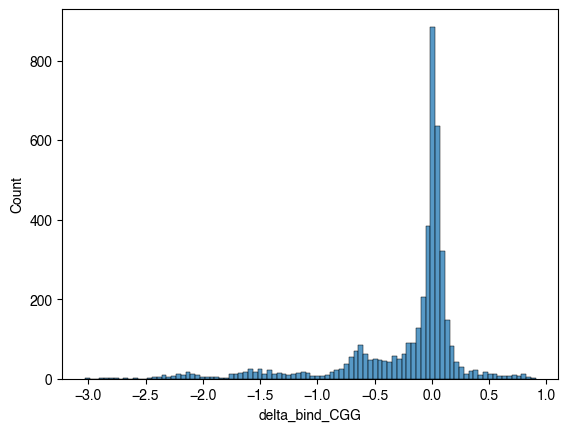

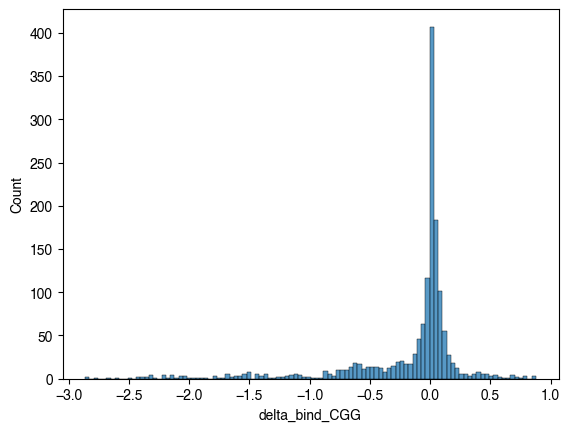

In [5]:
sns.histplot(data=dms_df, x="delta_bind_CGG")
plt.show()

sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG")
plt.show()

In [6]:
dms_df.loc[dms_df.single_nt].delta_bind_CGG.describe()

count    1503.000000
mean       -0.172883
std         0.507691
min        -2.863630
25%        -0.157505
50%         0.000000
75%         0.045450
max         0.877850
Name: delta_bind_CGG, dtype: float64

In [7]:
aa_order = pd.Index(list("RKHDEQNSTYWFAILMVGPC"))
def aa_order_key_fn(aa_index):
    return pd.Index(aa_order.get_loc(aa) for aa in aa_index)

In [8]:
dms_df.delta_bind_CGG.describe()

count    4397.000000
mean       -0.221130
std         0.540434
min        -3.028910
25%        -0.297030
50%        -0.005230
75%         0.047940
max         0.908430
Name: delta_bind_CGG, dtype: float64

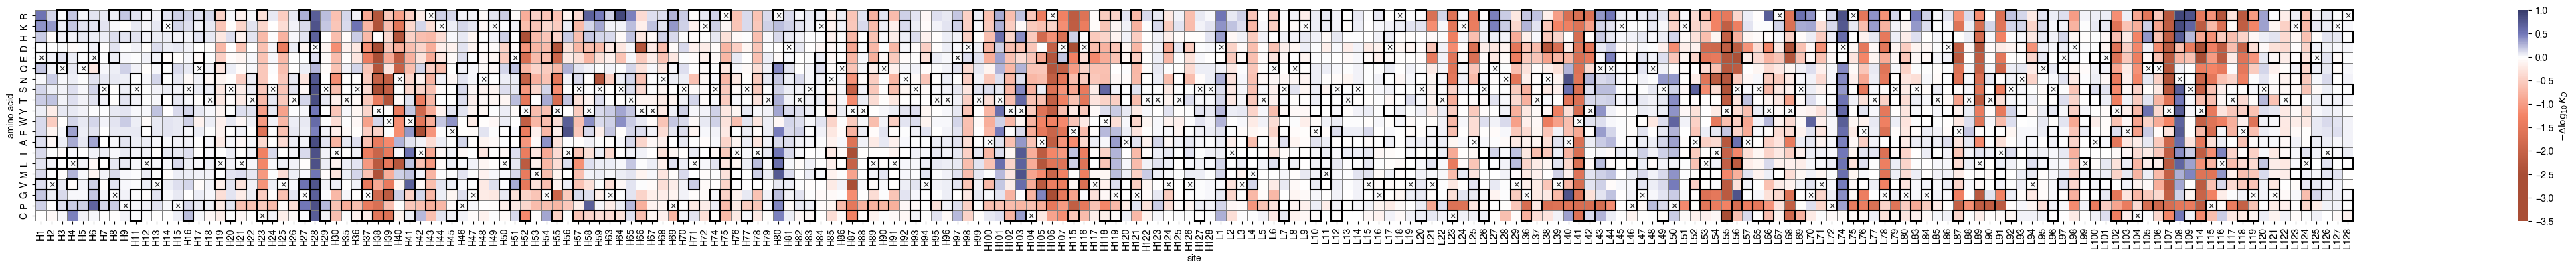

In [9]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind_CGG").fillna(0)
accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

bind_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)
accessible_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)
wt_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00D7"
# annot.iloc[~accessible_df.values.astype(bool)] = "\u2571"

site_labels_pretty = bind_df.columns.map(lambda x: x.split("-")[0] + str(int(x.split("-")[1])))

plt.figure(figsize=(50, 4))
ax = sns.heatmap(bind_df,
            annot=annot, fmt="", annot_kws=dict(fontweight='bold'),
            cmap=pc.affinity_dms.cmap, norm=pc.affinity_dms.norm,
            cbar_kws=dict(label=r"$-\Delta\log_{10} K_D$"),
            linewidths=0.5, linecolor='grey',
            square=True,
            xticklabels=site_labels_pretty,
)
plt.xlabel("site")
plt.ylabel("amino acid")

ax.collections[0].colorbar.ax.set_yscale('linear')

# Function to draw borders around accessible mutations
def draw_custom_borders(ax, cells):
    for cell in cells:
        i, j = cell
        rect = plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1.5, clip_on=False)
        ax.add_patch(rect)

# Specify accessible cells to have borders
cells_to_border = []
for i, j in zip(*np.where(accessible_df)):
    cells_to_border.append((i, j))
draw_custom_borders(ax, cells_to_border)

plt.tight_layout()
plt.savefig(f"{output_dir}/heatmap.bind.pdf")
plt.show()

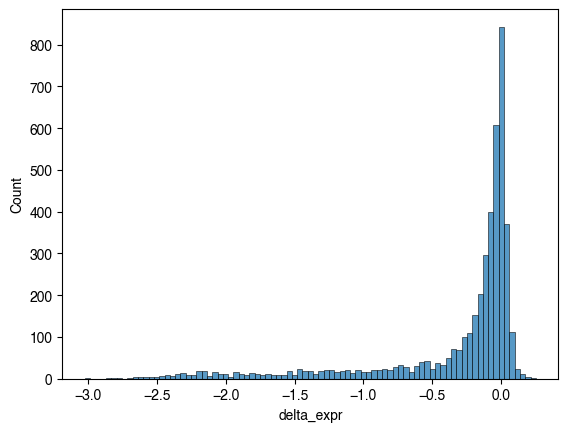

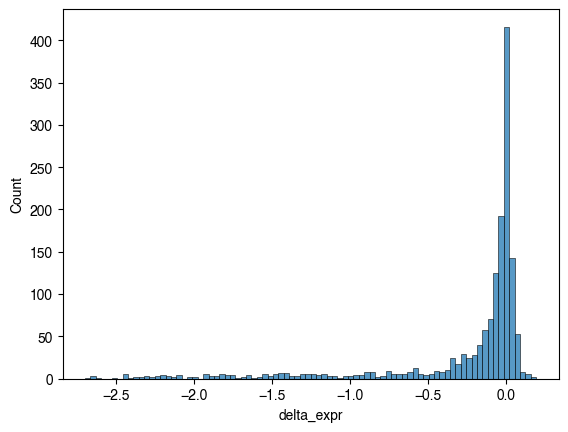

In [10]:
sns.histplot(data=dms_df, x="delta_expr")
plt.show()

sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr")
plt.show()

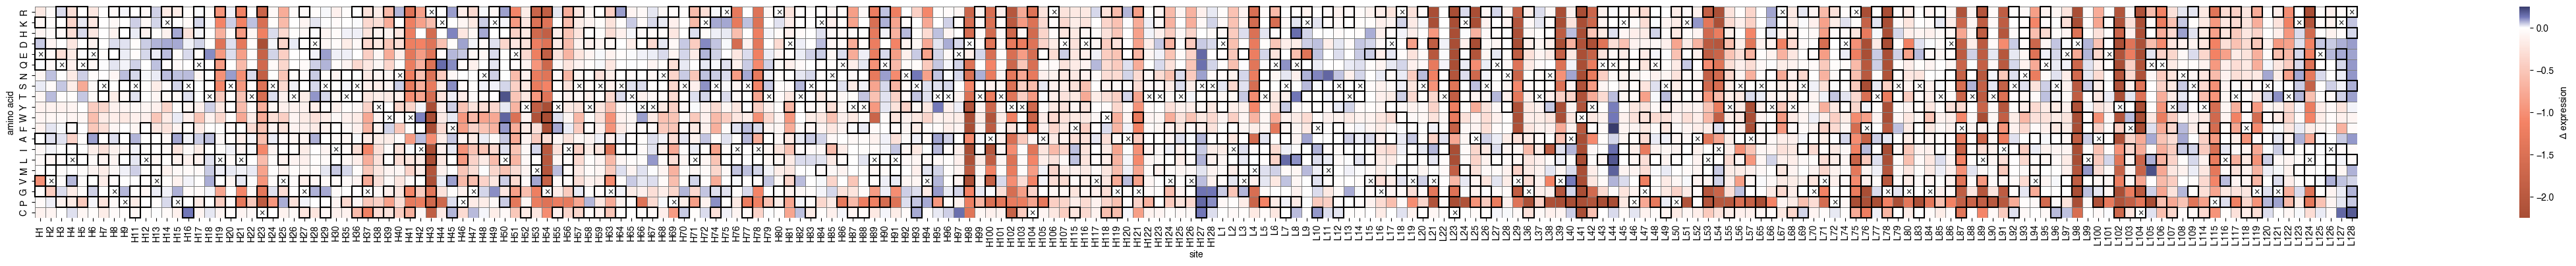

In [11]:
expr_df = dms_df.pivot(index="mutant", columns="site", values="delta_expr").fillna(0)
expr_df.sort_index(key=aa_order_key_fn, axis=0, inplace=True)

vmax = 1
vmin = -1

plt.figure(figsize=(50, 4))
ax = sns.heatmap(expr_df,
                 annot=annot, fmt="", annot_kws=dict(fontweight='bold'),
                 cmap=pc.expression_dms.cmap, norm=pc.expression_dms.norm,
                 cbar_kws=dict(label=r"$\Delta$ expression"),
                 linewidths=0.5, linecolor='grey',
                 square=True,
                 xticklabels=site_labels_pretty,
)

ax.collections[0].colorbar.ax.set_yscale('linear')

draw_custom_borders(ax, cells_to_border)

plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
plt.savefig(f"{output_dir}/heatmap.expr.pdf")
plt.show()

## Mutations in GC trees

Load in metadata

In [12]:
metadata = pd.read_csv(metadata_csv, index_col=0)
metadata.head()

,ngs_id,imm_duration,mouse,gc,strain,node,cell_type,plate,hc_barcode,lc_barcode,row,col
uid,,,,,,,,,,,,
D15_M1_GC1,PR-2-01,d15,1,1,wt,RP,GC,2,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC2,PR-2-01,d15,1,2,wt,RI,GC,3,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC3,PR-2-01,d15,1,3,wt,LI,GC,4,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M2_GC4,PR-2-01,d15,2,4,wt,RP,GC,5,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M3_GC5,PR-2-01,d15,3,5,wt,RP,GC,6,7,4,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12


Load in trees

In [13]:
trees = ut.load_trees(metadata, results, ranking_subdir)

GC metadata

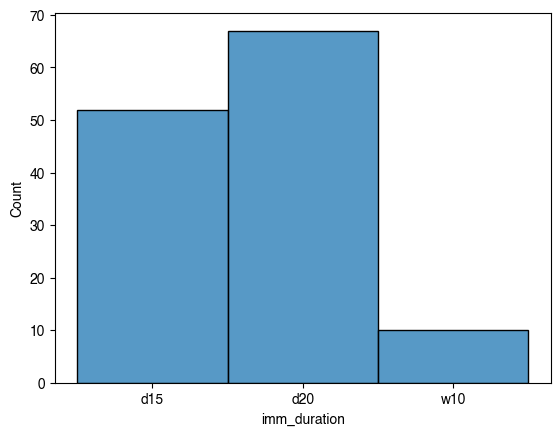

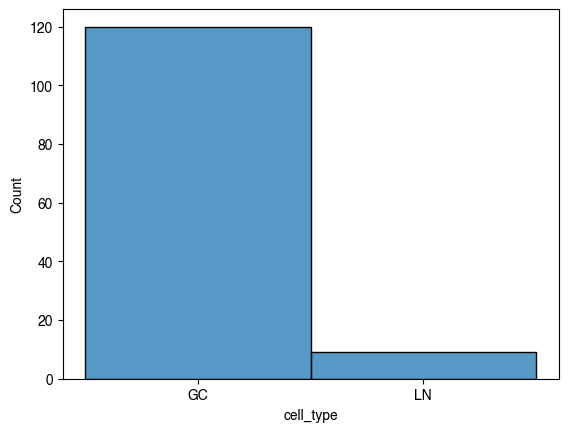

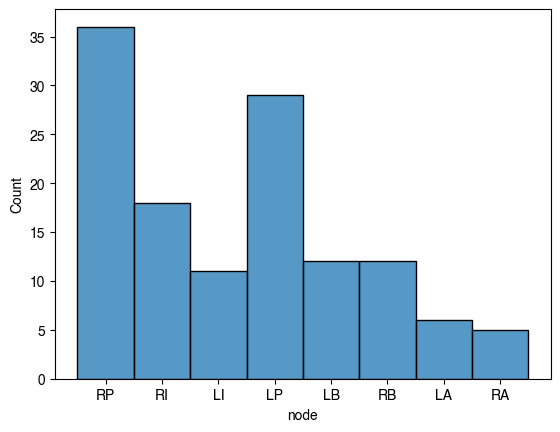

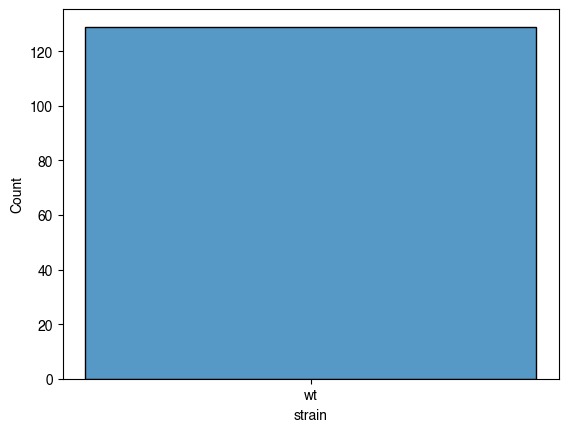

,ngs_id,imm_duration,mouse,gc,strain,node,cell_type,plate,hc_barcode,lc_barcode,row,col
uid,,,,,,,,,,,,
D15_M1_GC1,PR-2-01,d15,1,1,wt,RP,GC,2,9,9,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC2,PR-2-01,d15,1,2,wt,RI,GC,3,2,1,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M1_GC3,PR-2-01,d15,1,3,wt,LI,GC,4,14,2,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M2_GC4,PR-2-01,d15,2,4,wt,RP,GC,5,10,11,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
D15_M3_GC5,PR-2-01,d15,3,5,wt,RP,GC,6,7,4,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
...,...,...,...,...,...,...,...,...,...,...,...,...
W10_M27_GC125,PR-1-05,w10,27,125,wt,RI,LN,79,14,14,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
W10_M27_GC126,PR-1-05,w10,27,126,wt,LB,LN,82,15,15,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12
W10_M27_GC127,PR-1-06,w10,27,127,wt,RP,LN,77,14,14,A.B.C.D.E.F.G.H,1.2.3.4.5.6.7.8.9.10.11.12


In [14]:
# metadata.query("(strain == 'wt') & (cell_type == 'GC') & (time != 'w10')", inplace=True)
metadata.query("(strain == 'wt')", inplace=True)

sns.histplot(data=metadata, x="imm_duration")
plt.show()
sns.histplot(data=metadata, x="cell_type")
plt.show()
sns.histplot(data=metadata, x="node")
plt.show()
sns.histplot(data=metadata, x="strain")
plt.show()

metadata.to_csv(f"{output_dir}/metadata.renamed.csv")
metadata

In [15]:
pos_df = pd.read_csv(dms_sites, dtype=dict(site=pd.Int16Dtype()), index_col="site_scFv")
pos_df

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
1,E,H,1,GAG,FWRH1
2,V,H,2,GTG,FWRH1
3,Q,H,3,CAG,FWRH1
4,L,H,4,CTT,FWRH1
5,Q,H,5,CAG,FWRH1
...,...,...,...,...,...
231,L,L,124,CTA,FWRL4
232,E,L,125,GAA,FWRL4
233,I,L,126,ATA,FWRL4


In [16]:
dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,delta_bind_CGG,n_bc_bind_CGG,n_libs_bind_CGG,expr,delta_expr,n_bc_expr,n_libs_expr,WT,site
mutation,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,8.74239,0.11933,20,2,10.45318,-0.00246,20,2,False,H-001
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,8.60813,-0.01492,22,2,10.33348,-0.12216,22,2,False,H-001
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,8.63554,0.01249,18,2,10.50438,0.04874,18,2,False,H-001
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,8.62305,0.00000,23285,2,10.45565,0.00000,23285,2,True,H-001
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,8.75738,0.13433,29,2,10.34185,-0.11379,29,2,False,H-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,8.63400,0.01095,45,2,10.52908,0.07344,45,2,False,L-128
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,8.64386,0.02081,41,2,10.54211,0.08647,41,2,False,L-128
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,8.58887,-0.03418,28,2,10.49638,0.04073,28,2,False,L-128


In [17]:
igh_pos_map = pos_df.loc[pos_df.chain == "H", "site"].reset_index(drop=True)
igk_pos_map = pos_df.loc[pos_df.chain == "L", "site"].reset_index(drop=True)

## Mutation events

In [18]:
hits_df = pd.DataFrame(np.zeros_like(bind_df.values), index=bind_df.index, columns=bind_df.columns)

experiments = ["15-day", "20-day", "10-week", "LMP2A"]
suffixes = ["events", "abundance"]
for experiment, suffix in itertools.product(experiments, suffixes):
    dms_df[f"mutation {suffix} ({experiment})"] = 0

for gc, tree in trees.items():
    if gc not in metadata.index:
        print(f"WARNING: {gc} not found in metadata")
        continue
    if (metadata.strain[gc] == "wt") and (metadata.imm_duration[gc] == "d15"):
        suffix = "15-day"
    elif (metadata.strain[gc] == "wt") and (metadata.imm_duration[gc] == "d20"):
        suffix = "20-day"
    elif (metadata.strain[gc] == "wt") and (metadata.imm_duration[gc] == "w10"):
        suffix = "10-week"
    elif (metadata.strain[gc] == "LMP2A"):
        suffix = "LMP2A"
    else:
        raise ValueError(f"unknown gc {gc}")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        # Loop over new mutations.
        for mutation in set(node.mutations) - set(node.up.mutations):
            mutant = mutation[-1]
            if mutant != "*":
                site = dms_df.site[mutation]
                hits_df.loc[mutant, site] += 1
                dms_df.loc[mutation, f"mutation events ({suffix})"] += 1
        # Loop over all mutations.
        for mutation in node.mutations:
            mutant = mutation[-1]
            if mutant != "*":
                dms_df.loc[mutation, f"mutation abundance ({suffix})"] += node.abundance

# NOTE: "total" mutation abundance means day 15 and day 20
for suffix in suffixes:
    dms_df[f"mutation {suffix}"] = dms_df[f"mutation {suffix} (15-day)"] + dms_df[f"mutation {suffix} (20-day)"]

hits_df

site,H-001,H-002,H-003,H-004,H-005,H-006,H-007,H-008,H-009,H-011,...,L-119,L-120,L-121,L-122,L-123,L-124,L-125,L-126,L-127,L-128
mutant,,,,,,,,,,,,,,,,,,,,,
R,0.0,0.0,11.0,0.0,3.0,0.0,0.0,2.0,1.0,5.0,...,0.0,0.0,1.0,0.0,28.0,0.0,0.0,16.0,53.0,0.0
K,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.0,26.0,0.0,0.0
H,0.0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0
D,15.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,5.0,0.0,0.0,0.0,2.0,0.0,34.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,6.0,0.0,48.0,0.0,0.0,0.0,36.0,0.0
Q,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,4.0,32.0,0.0,24.0,0.0
N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.0,0.0,119.0,0.0,1.0,1.0,22.0,0.0
S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,9.0,1.0,1.0,0.0,0.0,3.0,0.0
T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,2.0,0.0,0.0,20.0,0.0,0.0,20.0,13.0,0.0


In [19]:
dms_df.loc["A105(H)G"]

target                          CGG_naive
wildtype                                A
position                               96
position_IMGT                         105
chain                                   H
annotation                          CDRH3
mutant                                  G
codon                                 GCA
single_nt                            True
bind_CGG                          9.06934
delta_bind_CGG                    0.44629
n_bc_bind_CGG                          20
n_libs_bind_CGG                         2
expr                             10.45229
delta_expr                       -0.00335
n_bc_expr                              20
n_libs_expr                             2
WT                                  False
site                                H-105
mutation events (15-day)               91
mutation abundance (15-day)          1781
mutation events (20-day)              104
mutation abundance (20-day)          2536
mutation events (10-week)         

In [20]:
hits_df.max().max()

np.float64(445.0)

## Comparing mutation incidence across mouse types

accessible mutations observed in 20-day mice: 894
accessible mutations not observed in 20-day mice: 611
inaccessible mutations observed in 20-day mice: 135
inaccessible mutations not observed in 20-day mice: 2760
accessible mutations observed in 10-week mice: 486
accessible mutations not observed in 10-week mice: 1019
inaccessible mutations observed in 10-week mice: 70
inaccessible mutations not observed in 10-week mice: 2825


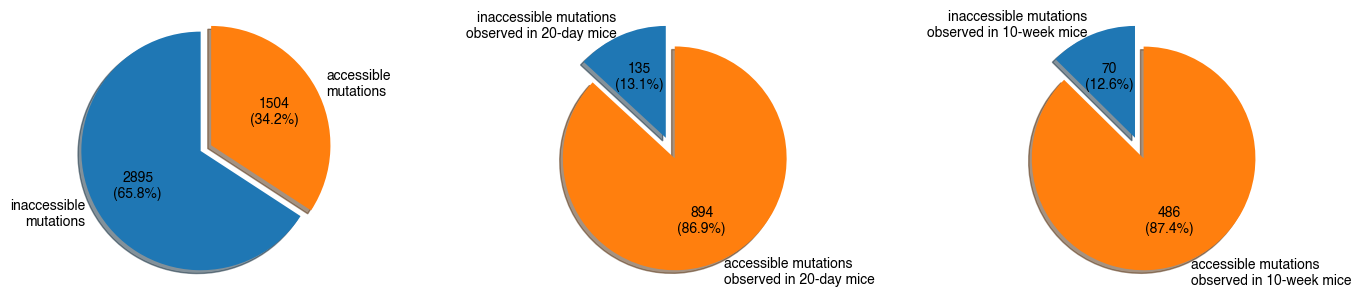

In [21]:
print(f"accessible mutations observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"accessible mutations not observed in 20-day mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")
print(f"inaccessible mutations observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])}")
print(f"inaccessible mutations not observed in 20-day mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] == 0)])}")

print(f"accessible mutations observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"accessible mutations not observed in 10-week mice: {len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")
print(f"inaccessible mutations observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])}")
print(f"inaccessible mutations not observed in 10-week mice: {len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] == 0)])}")

def func(pct, data):
    absolute = int(pct / 100 * np.sum(data))
    return f"{absolute:d}\n({pct:.1f}%)"

plt.figure(figsize=(14, 3))

plt.subplot(131)
data = [len(dms_df) - sum(dms_df.single_nt), sum(dms_df.single_nt)]
plt.pie(data,
        labels=("inaccessible\nmutations", "accessible\nmutations"),
        explode=(0, 0.1), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(132)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (20-day)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 20-day mice", "accessible mutations\nobserved in 20-day mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.subplot(133)
data = [len(dms_df.loc[~dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)]), len(dms_df.loc[dms_df.single_nt & (dms_df['mutation events (10-week)'] > 0)])]
plt.pie(data,
        labels=("inaccessible mutations\nobserved in 10-week mice", "accessible mutations\nobserved in 10-week mice"),
        explode=(0, 0.2), autopct=lambda pct: func(pct, data),
        shadow=True, startangle=90)
plt.axis('equal')

plt.tight_layout()
plt.savefig(f"{output_dir}/piechart.pdf")
plt.show()

# sns.boxplot(data=dms_df, x="single_nt", y="mutation events (20-day)")
# plt.show()

# sns.stripplot(data=dms_df, x="single_nt", y="mutation events (10-week)")
# plt.show()

In [22]:
dms_df[["single_nt", "mutation events (20-day)"]]

,single_nt,mutation events (20-day)
mutation,,
E1(H)A,True,4
E1(H)C,False,0
E1(H)D,True,7
E1(H)E,True,0
E1(H)F,False,0
...,...,...
R128(L)S,True,0
R128(L)T,False,0
R128(L)V,False,0


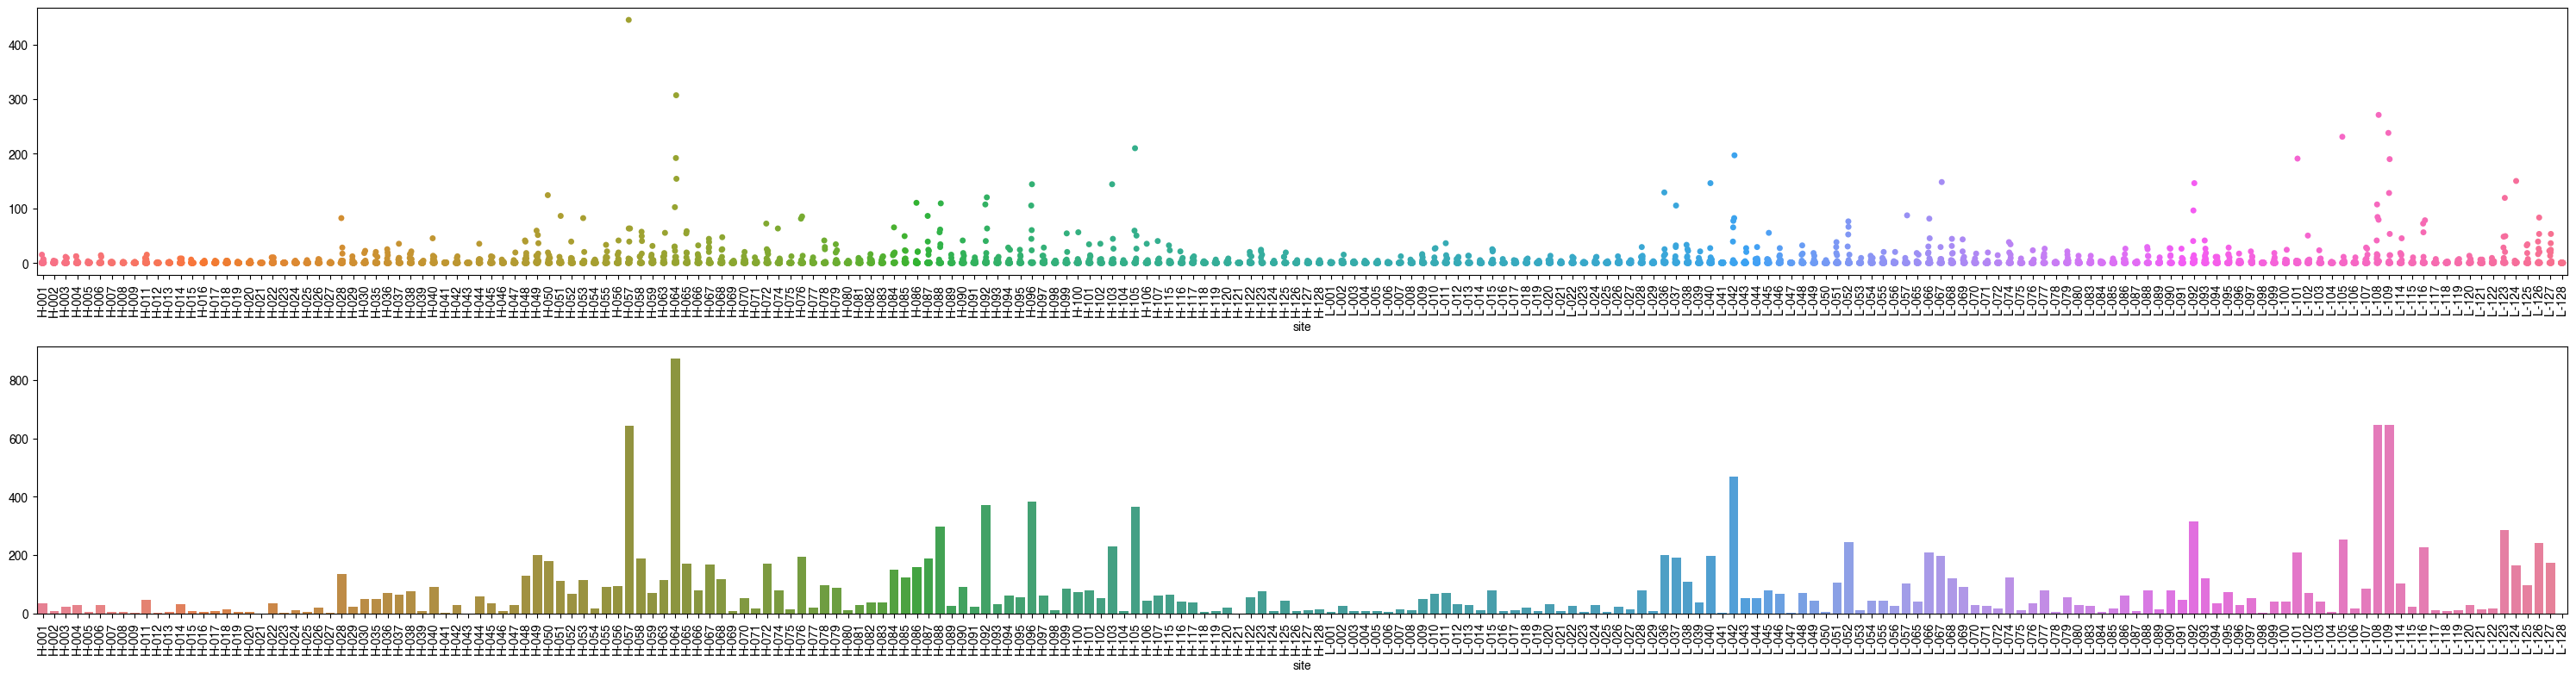

In [23]:
plt.figure(figsize=(30, 8))

plt.subplot(211)
g = sns.stripplot(data=hits_df)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.subplot(212, sharex=g)
g = sns.barplot(data=hits_df, errorbar=None, estimator=sum)
for item in g.get_xticklabels():
    item.set_rotation(90)

plt.tight_layout()
plt.show()

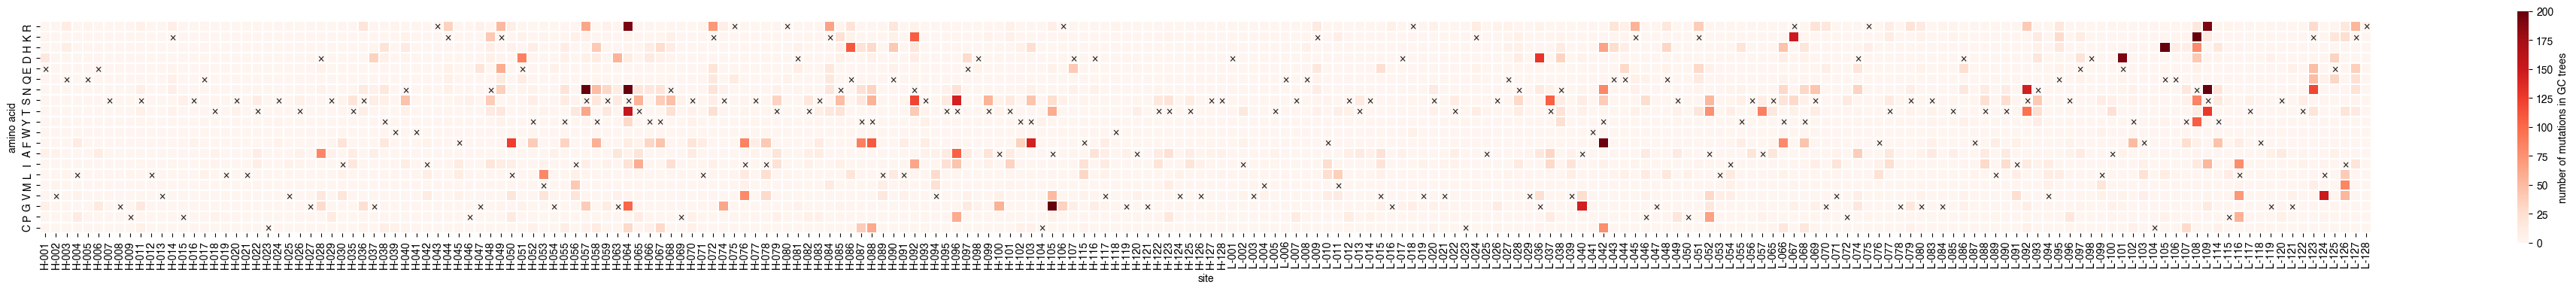

In [24]:
plt.figure(figsize=(50, 4))
sns.heatmap(hits_df, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="Reds",
#             vmin=100,
            vmax=200,
            cbar_kws=dict(label="number of mutations in GC trees"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.show()

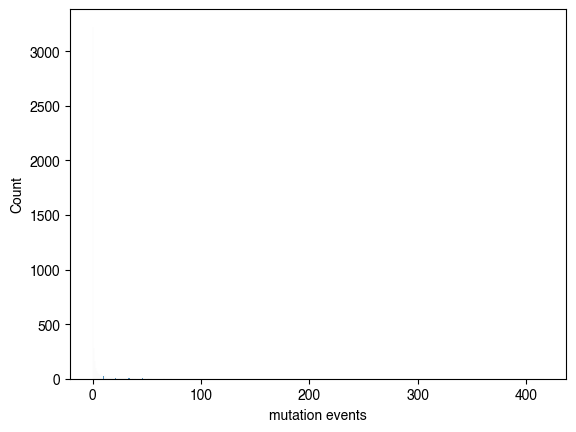

mutation
S57(H)N     416
S64(H)N     287
N108(L)K    250
Q105(L)H    213
S109(L)N    213
A105(H)G    195
S109(L)R    183
E101(L)D    181
S64(H)R     171
Y42(L)F     170
L124(L)V    143
S64(H)T     141
R67(L)K     136
A40(L)G     135
T96(H)S     135
S92(L)N     126
Y103(H)F    126
G36(L)D     120
S109(L)T    118
L50(H)F     112
Name: mutation events, dtype: int64

In [25]:
sns.histplot(data=dms_df, x="mutation events")
plt.show()

dms_df["mutation events"].sort_values(ascending=False)[:20]

## Add mutability to `dms_df`

In [26]:
from math import isnan
from Bio.codonalign.codonseq import CodonSeq


chigy_hc_passenger = pd.read_csv(chigy_hc_mut_rates, index_col=0)
chigy_lc_passenger = pd.read_csv(chigy_lc_mut_rates, index_col=0)

mutation_rates_nt = pd.concat([chigy_hc_passenger.head(-1), chigy_lc_passenger.head(-1)])
# Assert that we've glued things together covering all sites
assert (mutation_rates_nt.index == np.arange(len(mutation_rates_nt))).all()


# mutability = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_mutability.csv", sep=" ", index_col=0).squeeze("columns")
# substitution = pd.read_csv("../nextflow/data/mutability/MK_RS5NF_substitution.csv", sep=" ", index_col=0)

naive = next(iter(trees.values())).tree.sequence
igk_idx = 336

# padded_igh = "NN" + naive[:igk_idx] + "NN"
# padded_igk = "NN" + naive[igk_idx:] + "NN"
# # mutabilities of each nucleotide
# contexts = [padded_igh[(i - 2) : (i + 3)]
#                 for i in range(2, len(padded_igh) - 2)
#                ] + [padded_igk[(i - 2) : (i + 3)]
#                     for i in range(2, len(padded_igk) - 2)
#                    ]

# # mutation rates at each site in naive
# mutation_rates_nt = pd.concat((mutability[context] * substitution.loc[context] for context in contexts), axis=1).T.reset_index()

# now we want the above at the codon level

codons = CodonSeq(naive)

# assert len(contexts) == len(naive) == len(codons)

dms_df["mutation rate"] = np.nan

for codon_idx in range(codons.get_codon_num()):
    codon = CodonSeq(codons.get_codon(codon_idx))
    aa = codon.translate()
    for codon_pos in range(3):
        idx = 3 * codon_idx + codon_pos
        if idx < igk_idx:
            chain = "H"
            imgt_idx = igh_pos_map[idx // 3]
        else:
            chain = "L"
            imgt_idx = igk_pos_map[(idx - igk_idx) // 3]
        assert naive[idx] == codon[codon_pos]
        for alt_nt in "ACGT":
            if alt_nt != naive[idx]:
                mutated_codon = list(codon)
                mutated_codon[codon_pos] = alt_nt
                mutated_codon = CodonSeq("".join(mutated_codon))
                mutated_aa = mutated_codon.translate()
                if mutated_aa != "*" and mutated_aa != aa:
                    mutation = f"{aa}{imgt_idx}({chain}){mutated_aa}"
                    if np.isnan(dms_df.loc[mutation, "mutation rate"]):
                        dms_df.loc[mutation, "mutation rate"] = 0
                    dms_df.loc[mutation, "mutation rate"] += mutation_rates_nt.loc[idx, alt_nt]
dms_df

/Users/matsen/re/gcreplay/.venv/lib/python3.11/site-packages/Bio/codonalign/__init__.py:21: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  warnings.warn(


,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,mutation abundance (15-day),mutation events (20-day),mutation abundance (20-day),mutation events (10-week),mutation abundance (10-week),mutation events (LMP2A),mutation abundance (LMP2A),mutation events,mutation abundance,mutation rate
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,8.74239,...,2,4,4,0,0,0,0,6,6,0.000006
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,8.60813,...,0,0,0,0,0,0,0,0,0,NaN
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,8.63554,...,3,7,54,5,8,0,0,10,57,0.000725
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,8.62305,...,0,0,0,0,0,0,0,0,0,NaN
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,8.75738,...,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,8.63400,...,0,0,0,0,0,0,0,0,0,NaN
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,8.64386,...,0,0,0,0,0,0,0,0,0,NaN
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,8.58887,...,0,0,0,0,0,0,0,0,0,NaN


In [27]:
assert (~dms_df.single_nt & (dms_df["mutation rate"] > 0)).sum() == 0

<Axes: xlabel='delta_bind_CGG', ylabel='Density'>

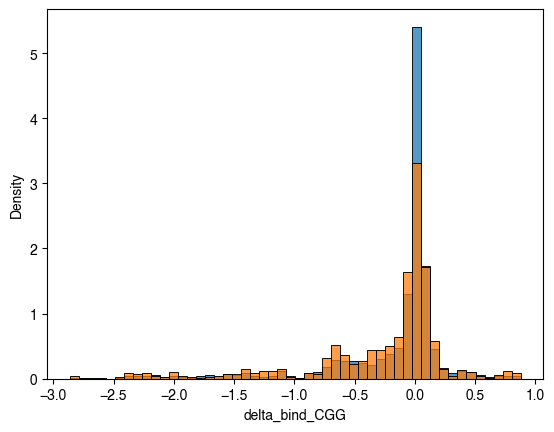

In [28]:
sns.histplot(data=dms_df.query("single_nt == True"), x="delta_bind_CGG", bins=50, stat="density")
sns.histplot(data=dms_df.query("single_nt == True"), x="delta_bind_CGG", weights="mutation rate", bins=50, stat="density")

In [29]:
dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate"]]

,delta_bind_CGG,wildtype,mutant,mutation events,mutation rate
mutation,,,,,
Q86(H)H,-0.00100,Q,H,103,0.004546
Y88(H)F,0.05302,Y,F,105,0.005637
N108(L)Y,0.73212,N,Y,106,0.004310
N92(H)S,-0.09063,N,S,106,0.006922
K123(L)N,-0.04793,K,N,109,0.008890
L50(H)F,-0.00532,L,F,112,0.004655
S109(L)T,0.01760,S,T,118,0.007761
G36(L)D,-0.59849,G,D,120,0.010422
S92(L)N,0.03607,S,N,126,0.006265


In [30]:
dms_df.loc["N108(L)E"]

target                          CGG_naive
wildtype                                N
position                              219
position_IMGT                         108
chain                                   L
annotation                          CDRL3
mutant                                  E
codon                                 AAC
single_nt                           False
bind_CGG                          7.90154
delta_bind_CGG                   -0.72151
n_bc_bind_CGG                          47
n_libs_bind_CGG                         2
expr                             10.38958
delta_expr                       -0.06607
n_bc_expr                              47
n_libs_expr                             2
WT                                  False
site                                L-108
mutation events (15-day)                0
mutation abundance (15-day)             0
mutation events (20-day)                2
mutation abundance (20-day)             2
mutation events (10-week)         

In [31]:
pos_df.loc[90:100]

,amino_acid,chain,site,KI_codon,annotation
site_scFv,,,,,
90,T,H,99,ACA,FWRH3
91,A,H,100,GCC,FWRH3
92,T,H,101,ACA,FWRH3
93,Y,H,102,TAT,FWRH3
94,Y,H,103,TAC,FWRH3
95,C,H,104,TGT,FWRH3
96,A,H,105,GCA,CDRH3
97,R,H,106,AGG,CDRH3
98,D,H,107,GAC,CDRH3


In [32]:
# most_mutated_df = dms_df.loc[(dms_df["mutation events"]>100)].sort_values("mutation events")[["delta_bind_CGG", "wildtype", "mutant", "mutation events", "mutation rate", "mutation rate RS5NF"]]

In [33]:
# plt.figure(figsize=(10, 8))  # Set the size of the plot

# # Create scatter plot
# plt.scatter(most_mutated_df['mutation rate'], most_mutated_df['mutation rate RS5NF'], alpha=0.6)

# # Label each point
# for i in range(len(most_mutated_df)):
#     plt.text(most_mutated_df['mutation rate'][i], most_mutated_df['mutation rate RS5NF'][i], most_mutated_df.index[i], fontsize=8)

# # Set labels and title
# plt.xlabel('Mutation Rate')
# plt.ylabel('Mutation Rate RS5NF')
# plt.title('Mutation Rate vs Mutation Rate RS5NF')

# plt.show()

In [34]:
query_str = "(single_nt == True) & (WT == False)"
# Slope is ML estimator for Poisson regression using an identity link function.
# Here we set this up for the complete dataset but also use the same formula for the per-timepoint data below.
slope = dms_df.query(query_str)["mutation abundance"].sum() / dms_df.query(query_str)["mutation rate"].sum()
rate_grid = np.geomspace(1e-4, dms_df.query(query_str)["mutation rate"].max(), 100)
predicted_events = slope * dms_df.query(query_str)["mutation rate"]
dms_df["mutation enrichment"] = np.log10((.5 + dms_df.query(query_str)["mutation abundance"]) / (.5 + predicted_events))

In [35]:
def plot_one_measured_var(axs, dms_df, query_str, dependent_var, measured_var, cmap, norm, linthresh=1, linscale=0.2):
    """
    Generate a row of plots for a given measured variable.
    
    Args:
        axs (array): Array of matplotlib axes to fill.
        dms_df (pd.DataFrame): Dataframe containing the data.
        query_str (str): Query string to filter the data.
        dependent_var (str): Name of the dependent variable column.
        measured_var (str): Name of the measured variable (e.g., "affinity" or "expression").
        bins (list): Bin edges for the point plots.
        cmap: Colormap for scatter plots.
        norm: Normalization for colormap.
        linthresh (float): Linthresh for symlog scaling.
        linscale (float): Linscale for symlog scaling.
    """
    data = dms_df.query(query_str).sort_values(by=f"delta_{measured_var}", key=lambda val: np.abs(val)).dropna()
    max_y = data[dependent_var].max() * 1.5
    min_y = -1


    # Left plot: Mutation abundance vs mutation rate
    ax0 = axs[0]
    scatter = ax0.scatter(
        data["mutation rate"], data[dependent_var],
        c=data[f"delta_{measured_var}"], s=13, alpha=0.8, cmap=cmap, norm=norm,
        clip_on=False, edgecolors="k", linewidths=0.1
    )
    plt.colorbar(scatter, ax=ax0, label=fr"$\Delta$ {measured_var}")
    ax0.collections[0].colorbar.ax.set_yscale('linear')
    ax0.set_xscale("log")
    ax0.set_yscale("symlog", linthresh=linthresh, linscale=linscale)
    ax0.set_xlabel("mutation rate")
    ax0.set_ylabel(dependent_var)
    ax0.set_ylim(top=max_y, bottom=min_y)

    log_mutation_rate = np.log10(data["mutation rate"])
    y0 = data[dependent_var]

    slope = data["mutation abundance"].sum() / data["mutation rate"].sum()
    rate_grid = np.geomspace(1e-4, data["mutation rate"].max(), 100)
    ax0.plot(rate_grid, slope*rate_grid, color="k", lw=1)
    
    # Compute Spearman's rho for log mutation rate vs dependent variable
    rho0, _ = spearmanr(log_mutation_rate, y0)
    print(f"Spearman's ρ for log(mutation rate) vs {dependent_var}: {rho0:.4f}")

    # Middle plot: Delta affinity vs mutation abundance
    ax1 = axs[1]
    scatter = ax1.scatter(
        data[f"delta_{measured_var}"],
        data[dependent_var],
        s=6.5,
        alpha=0.5,
        c=np.log10(data["mutation rate"]),
        cmap="viridis",
        clip_on=False,
    )
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label("$\log_{10}$ mutation rate")

    ax1.axhline(0, color="k", linestyle="--", linewidth=1)
    ax1.axvline(0, color="k", linestyle="--", linewidth=1)
    ax1.set_xlabel(fr"$\Delta$ {measured_var}")
    ax1.set_ylabel(dependent_var)
    ax1.set_yscale("symlog", linthresh=linthresh, linscale=linscale)
    ax1.set_ylim(top=max_y, bottom=min_y)

    x1 = data[f"delta_{measured_var}"]
    y1 = data[dependent_var]

    rho1, _ = spearmanr(x1, y1)
    print(f"Spearman's ρ for Δ{measured_var} vs {dependent_var}: {rho1:.4f}")
        
    # Right plot: Mutation enrichment lowess
    predicted_events = slope * data["mutation rate"]
    data["mutation enrichment"] = np.log10((0.5 + data[dependent_var]) / (0.5 + predicted_events))
    ax2 = axs[2]
    regplot_lowess_ci(data=dms_df.query(query_str).dropna(),
            x=f"delta_{measured_var}", y="mutation enrichment",
            ci_level=95, n_boot=100,
            scatter_kwargs=dict(s=13, alpha=0.5, color="grey"),
            line_kwargs=dict(color="xkcd:orange"),
            ax=ax2,
            )
    ax2.axhline(0, color="k", linestyle="--", linewidth=1)
    ax2.axvline(0, color="k", linestyle="--", linewidth=1)
    ax2.set_xlabel(fr"$\Delta$ {measured_var}")
    ax2.set_ylabel("mutation enrichment")
    

def mutations_plot(dms_df, timepoint=""):
    """
    Generate a 2x3 plot layout with rows for affinity and expression.
    
    Args:
        dms_df (pd.DataFrame): Dataframe containing the data.
        dependent_var (str): Name of the dependent variable column.
        output_dir (str): Output directory for saving the plot.
    """

    dms_df = dms_df.copy()
    dms_df.rename(columns={"delta_bind_CGG": "delta_affinity"}, inplace=True)
    dms_df.rename(columns={"delta_expr": "delta_expression"}, inplace=True)

    if timepoint == "":
        dependent_var = "mutation abundance"
    else:
        dependent_var = f"mutation abundance ({timepoint})"

    query_str="(single_nt == True) & (WT == False)"
    
    plt.figure(figsize=(13, 7))
    axs = [plt.subplot(231), plt.subplot(232), plt.subplot(233)]
    plot_one_measured_var(
        axs, dms_df, query_str, dependent_var, "affinity",
        cmap=pc.affinity_dms.cmap, norm=pc.affinity_dms.norm
    )
    
    axs = [plt.subplot(234), plt.subplot(235), plt.subplot(236)]
    plot_one_measured_var(
        axs, dms_df, query_str, dependent_var, "expression",
        cmap=pc.expression_dms.cmap, norm=pc.expression_dms.norm
    )
    
    if timepoint != "":
        plt.suptitle(f"{timepoint}")
    plt.tight_layout()
    plt.savefig(f"{output_dir}/eventsVsrate{timepoint}.pdf")
    plt.show()


Spearman's ρ for log(mutation rate) vs mutation abundance: 0.6615
Spearman's ρ for Δaffinity vs mutation abundance: 0.2214
Spearman's ρ for log(mutation rate) vs mutation abundance: 0.6615
Spearman's ρ for Δexpression vs mutation abundance: 0.3967


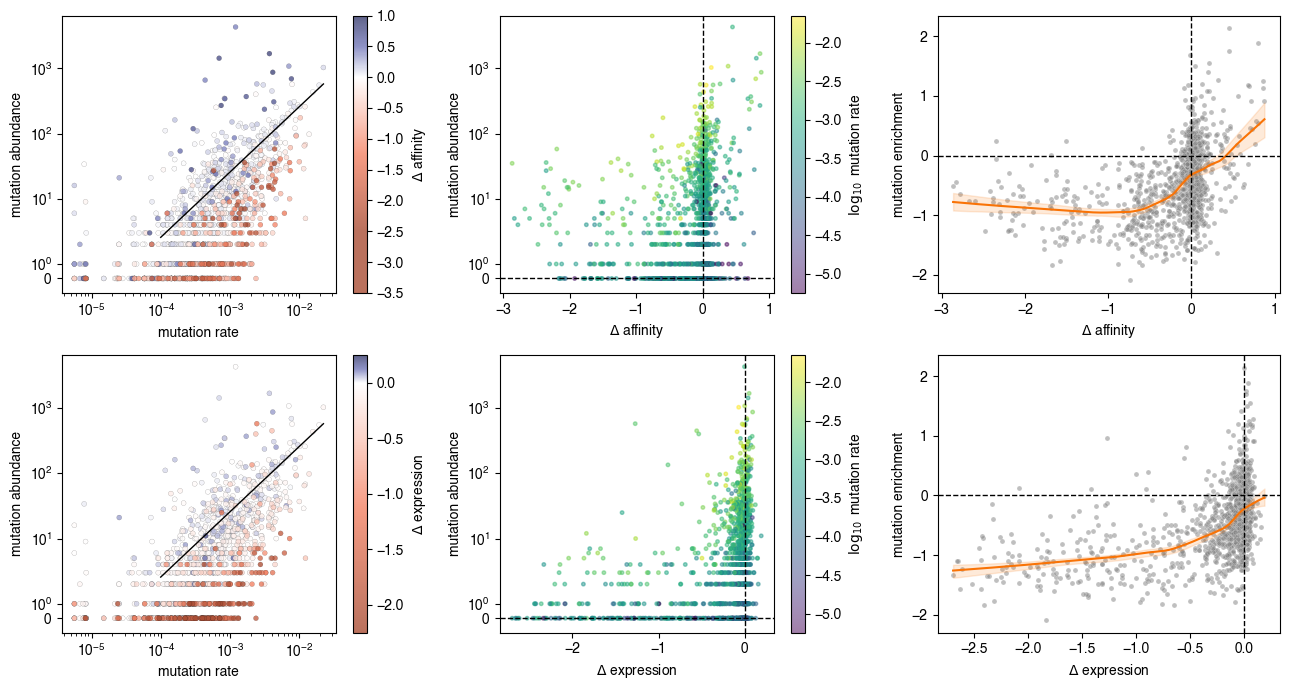

Spearman's ρ for log(mutation rate) vs mutation abundance (15-day): 0.6507
Spearman's ρ for Δaffinity vs mutation abundance (15-day): 0.1946
Spearman's ρ for log(mutation rate) vs mutation abundance (15-day): 0.6507
Spearman's ρ for Δexpression vs mutation abundance (15-day): 0.3434


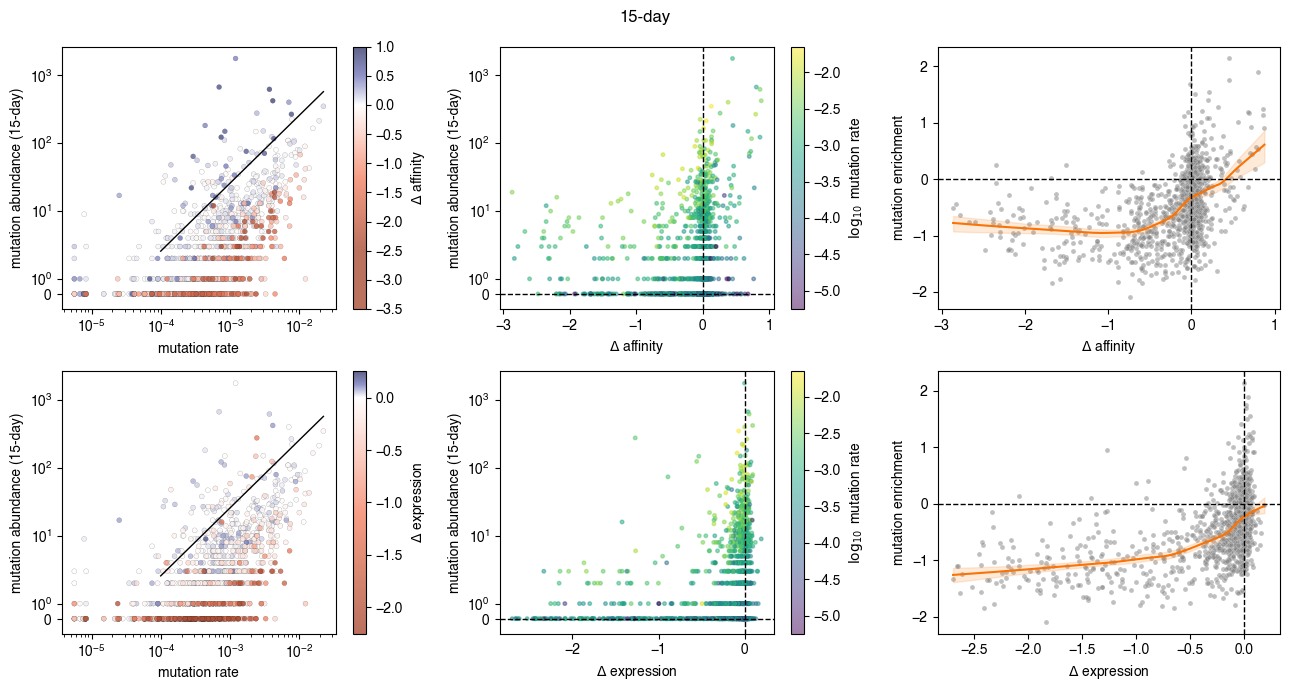

Spearman's ρ for log(mutation rate) vs mutation abundance (20-day): 0.6324
Spearman's ρ for Δaffinity vs mutation abundance (20-day): 0.2046
Spearman's ρ for log(mutation rate) vs mutation abundance (20-day): 0.6324
Spearman's ρ for Δexpression vs mutation abundance (20-day): 0.3821


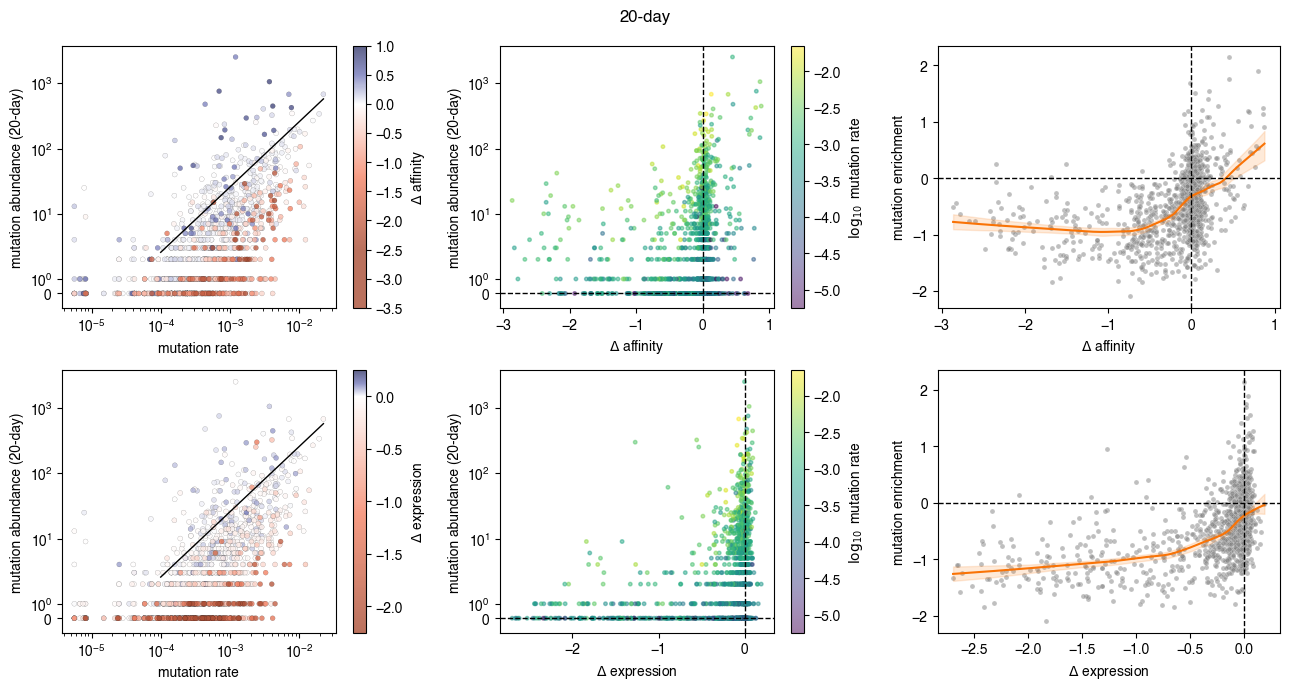

In [36]:
mutations_plot(dms_df)
mutations_plot(dms_df, timepoint="15-day")
mutations_plot(dms_df, timepoint="20-day")

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -1601.2         True       359.13 
1                    -1762.1         True       313.01 
2                    -1751.4         True       312.13 
3                                   False              
4                                   False              
5                                   False              

Min BIC (Bayesian Information Criterion) suggests best model

                    Breakpoint Regression Results                     
No. Observations                     1275
No. Model Parameters     

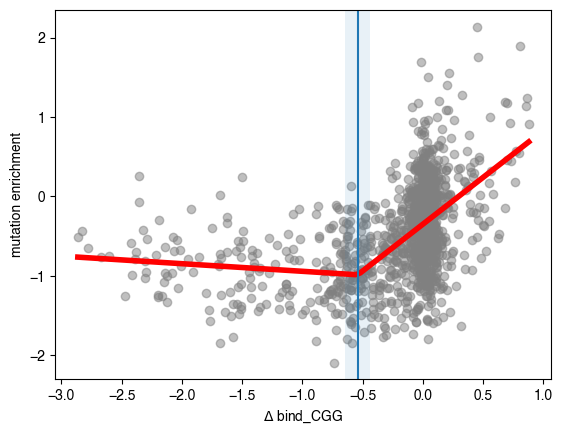

In [37]:
def do_piecewise_regression(measured_var, n_breakpoints):
    query_str="(single_nt == True) & (WT == False)"
    data = dms_df.query(query_str).sort_values(by=f"delta_{measured_var}", key=lambda val: np.abs(val)).dropna()
    delta_thing = data[f"delta_{measured_var}"].to_numpy()
    enrichment = data["mutation enrichment"].to_numpy()

    if n_breakpoints is None:
        ms = piecewise_regression.ModelSelection(delta_thing, enrichment, max_breakpoints=5)
        return ms
    #else:
    pw_fit = piecewise_regression.Fit(delta_thing, enrichment, n_breakpoints=n_breakpoints)

    pw_fit.plot_data(color="grey", alpha=0.5)
    pw_fit.plot_fit(color="red", linewidth=4)
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()
    pw_fit.summary()
    plt.xlabel(f"$\Delta$ {measured_var}")
    plt.ylabel("mutation enrichment")
    fig = plt.gcf()
    return pw_fit, fig

do_piecewise_regression("bind_CGG", None)
pw_fit, fig = do_piecewise_regression("bind_CGG", 1)
fig.savefig(f"{output_dir}/piecewise_regression.bind.pdf")

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                    -1712.4         True       329.13 
1                    -1799.2         True       304.04 
2                    -1792.9         True       302.13 
3                                   False              
4                                   False              
5                                   False              

Min BIC (Bayesian Information Criterion) suggests best model

                    Breakpoint Regression Results                     
No. Observations                     1275
No. Model Parameters     

(<piecewise_regression.main.Fit at 0x30ecae810>,
 <Figure size 640x480 with 1 Axes>)

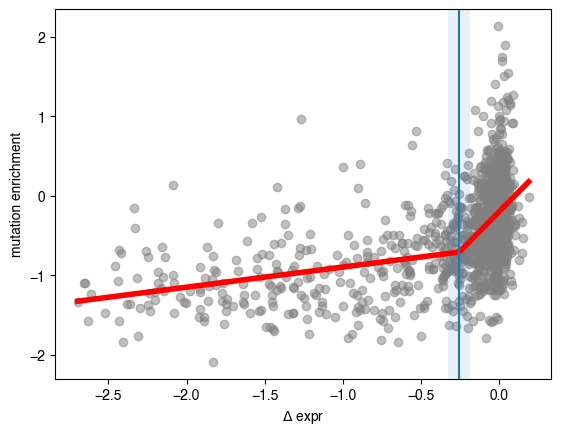

In [38]:
do_piecewise_regression("expr", None)
do_piecewise_regression("expr", 1)

In [39]:
query_str="(single_nt == True) & (WT == False)"
data = dms_df.query(query_str).dropna()

predicted_values = pw_fit.predict(data['delta_bind_CGG'].values)
data['enrichment affinity residual'] = data['mutation enrichment'] - predicted_values

In [40]:
data["delta_avidity"] = data["delta_bind_CGG"] + data["delta_expr"]

rho, _ = spearmanr(data["delta_bind_CGG"], data["mutation enrichment"])
print(f"Spearman's ρ for Δaffinity vs mutation enrichment: {rho:.4f}")

rho, _ = spearmanr(data["delta_expr"], data["mutation enrichment"])
print(f"Spearman's ρ for Δexpression vs mutation enrichment: {rho:.4f}")

rho, _ = spearmanr(data["delta_avidity"], data["mutation enrichment"])
print(f"Spearman's ρ for Δavidity vs mutation enrichment: {rho:.4f}")

rho, _ = spearmanr(data["delta_expr"], data["enrichment affinity residual"])
print(f"Spearman's ρ for Δexpression vs enrichment affinity residual: {rho:.4f}")

Spearman's ρ for Δaffinity vs mutation enrichment: 0.4622
Spearman's ρ for Δexpression vs mutation enrichment: 0.5222
Spearman's ρ for Δavidity vs mutation enrichment: 0.5530
Spearman's ρ for Δexpression vs enrichment affinity residual: 0.2896


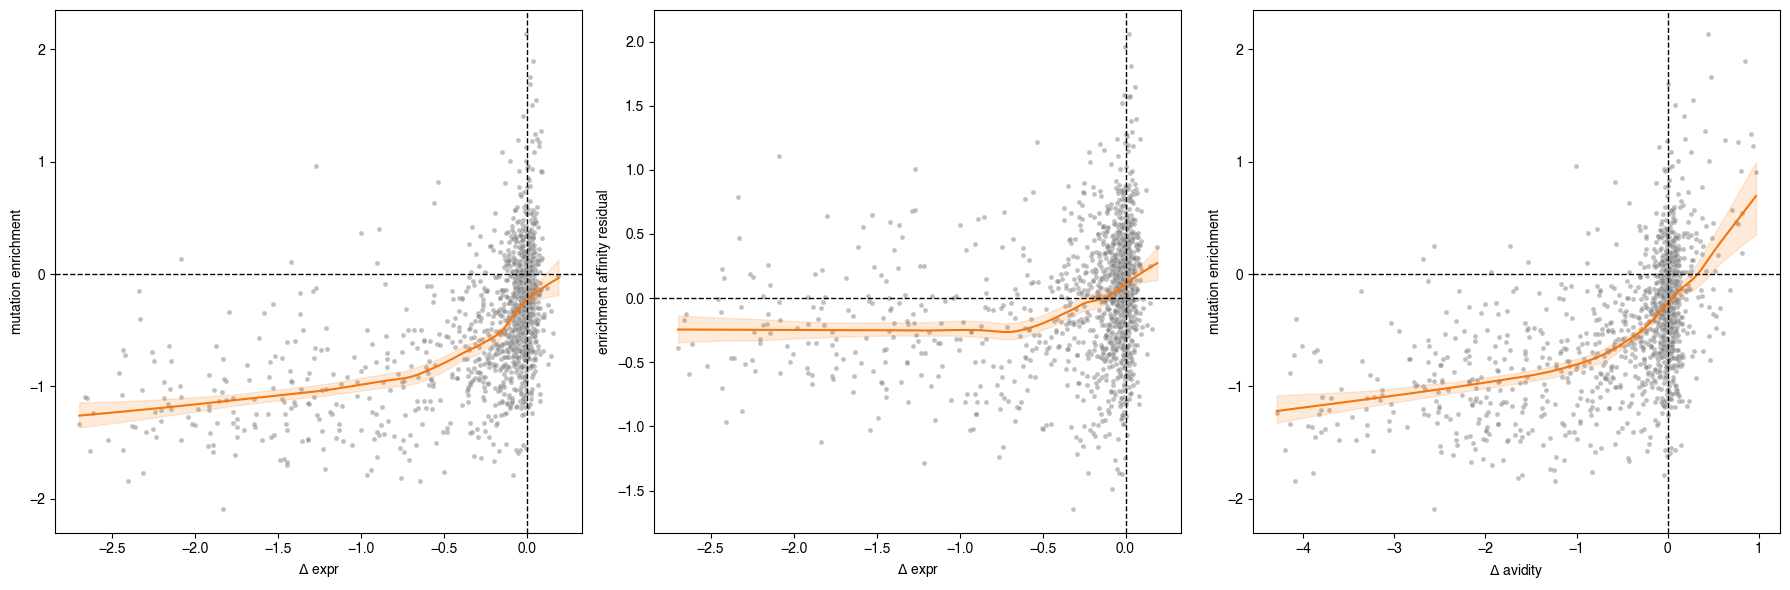

In [41]:
def plot_enrichment_vs_delta(measured_var, outcome_var, ax):
    regplot_lowess_ci(data=data,
            x=f"delta_{measured_var}", y=outcome_var ,
            ci_level=95, n_boot=100,
            scatter_kwargs=dict(s=13, alpha=0.5, color="grey"),
            line_kwargs=dict(color="xkcd:orange"),
            ax=ax,
            )
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel(fr"$\Delta$ {measured_var}")
    ax.set_ylabel(outcome_var)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
plot_enrichment_vs_delta("expr", "mutation enrichment", axs[0])
plot_enrichment_vs_delta("expr", "enrichment affinity residual", axs[1])
plot_enrichment_vs_delta("avidity", "mutation enrichment", axs[2])
plt.tight_layout()
plt.savefig(f"{output_dir}/three-lowess-supp.pdf")

Event / rate Vs affinity (getting at selection sensitivity)

In [42]:
gain_thresh = 0.3
loss_thresh = -1
dms_df.loc[~dms_df.delta_bind_CGG.isna(), "affinity change stratum"] = "affinity neutral"
dms_df.loc[dms_df.delta_bind_CGG > gain_thresh, "affinity change stratum"] = "affinity gain"
dms_df.loc[dms_df.delta_bind_CGG < loss_thresh, "affinity change stratum"] = "affinity loss"

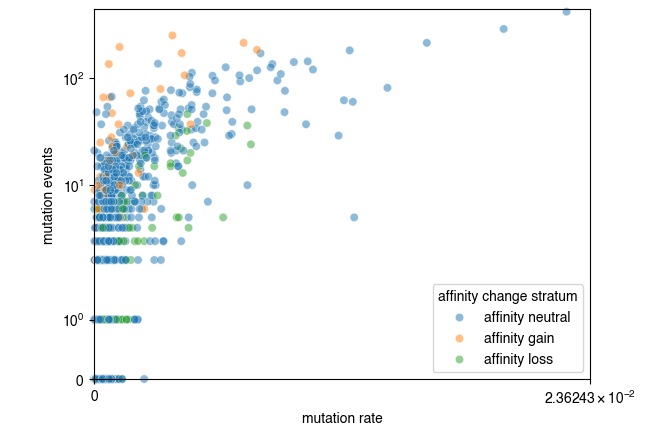

In [43]:
sns.scatterplot(data=dms_df, hue="affinity change stratum", y="mutation events", x="mutation rate", alpha=0.5, clip_on=False)
plt.xscale("symlog")
plt.yscale("symlog")
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

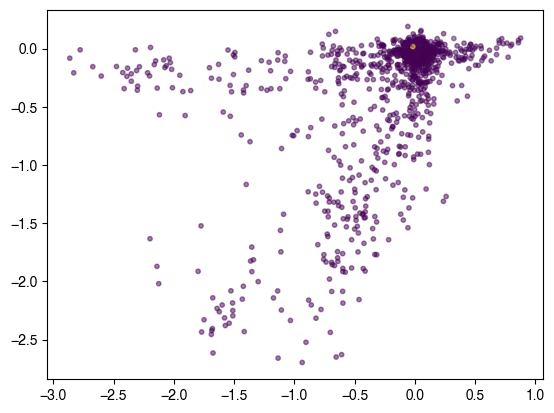

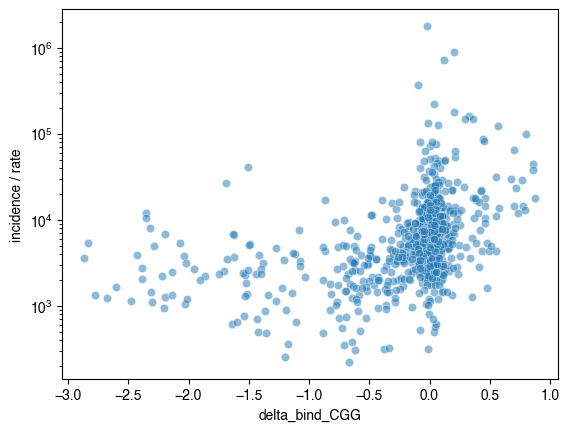

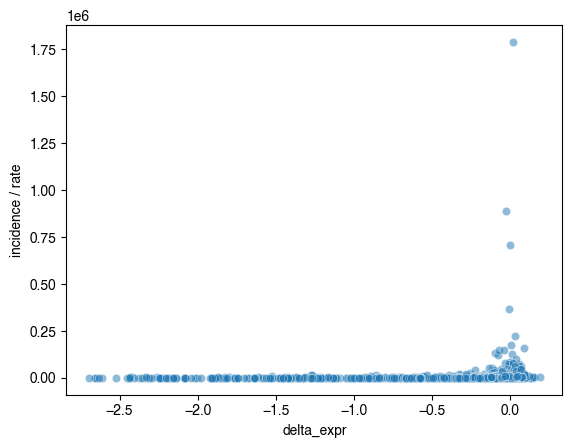

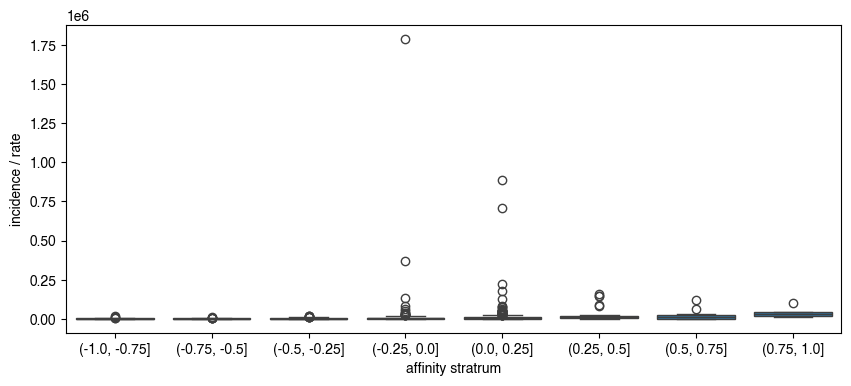

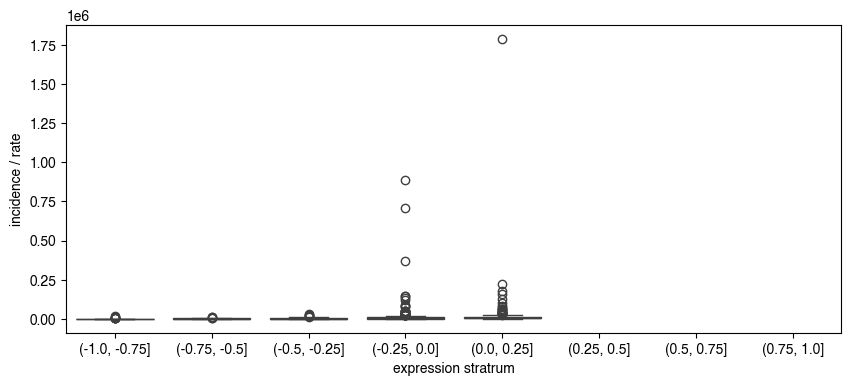

/Users/matsen/re/gcreplay/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


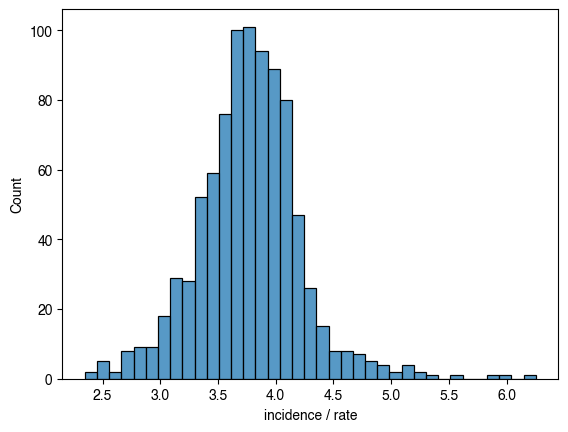

In [44]:
affinity_incidence_rate_df = dms_df[["delta_bind_CGG", "delta_expr", "mutation events (20-day)", "mutation rate"]].copy()
affinity_incidence_rate_df["incidence / rate"] = affinity_incidence_rate_df["mutation events (20-day)"] / affinity_incidence_rate_df["mutation rate"]

bins = np.linspace(-1, 1, 9)
affinity_incidence_rate_df["affinity stratrum"] = pd.cut(affinity_incidence_rate_df["delta_bind_CGG"], bins=bins)
affinity_incidence_rate_df["expression stratrum"] = pd.cut(affinity_incidence_rate_df["delta_expr"], bins=bins)

plt.scatter(affinity_incidence_rate_df.delta_bind_CGG, affinity_incidence_rate_df.delta_expr, c=affinity_incidence_rate_df["incidence / rate"], alpha=0.5, s=10)
plt.show()

sns.scatterplot(data=affinity_incidence_rate_df, x="delta_bind_CGG", y="incidence / rate", alpha=0.5)
plt.yscale("log")
plt.show()
sns.scatterplot(data=affinity_incidence_rate_df, x="delta_expr", y="incidence / rate", alpha=0.5)
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="affinity stratrum", y="incidence / rate")
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

sns.histplot(x=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()

In [45]:
affinity_incidence_rate_df

,delta_bind_CGG,delta_expr,mutation events (20-day),mutation rate,incidence / rate,affinity stratrum,expression stratrum
mutation,,,,,,,
E1(H)A,0.11933,-0.00246,4,0.000006,709451.963964,"(0.0, 0.25]","(-0.25, 0.0]"
E1(H)C,-0.01492,-0.12216,0,NaN,NaN,"(-0.25, 0.0]","(-0.25, 0.0]"
E1(H)D,0.01249,0.04874,7,0.000725,9660.529997,"(0.0, 0.25]","(0.0, 0.25]"
E1(H)E,0.00000,0.00000,0,NaN,NaN,"(-0.25, 0.0]","(-0.25, 0.0]"
E1(H)F,0.13433,-0.11379,0,NaN,NaN,"(0.0, 0.25]","(-0.25, 0.0]"
...,...,...,...,...,...,...,...
R128(L)S,0.01095,0.07344,0,NaN,NaN,"(0.0, 0.25]","(0.0, 0.25]"
R128(L)T,0.02081,0.08647,0,NaN,NaN,"(0.0, 0.25]","(0.0, 0.25]"
R128(L)V,-0.03418,0.04073,0,NaN,NaN,"(-0.25, 0.0]","(0.0, 0.25]"


/Users/matsen/re/gcreplay/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


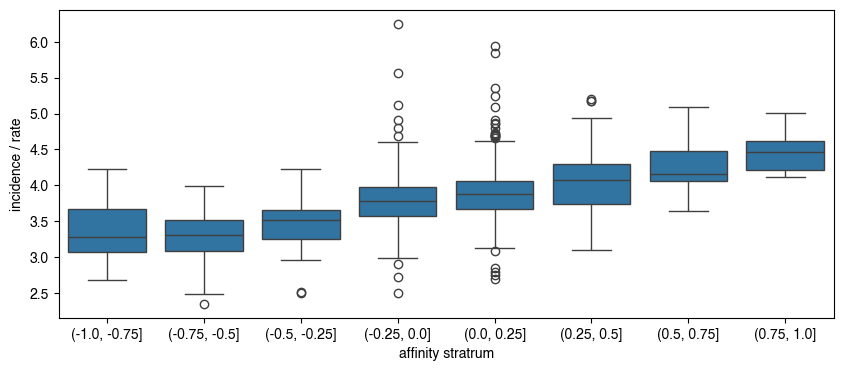

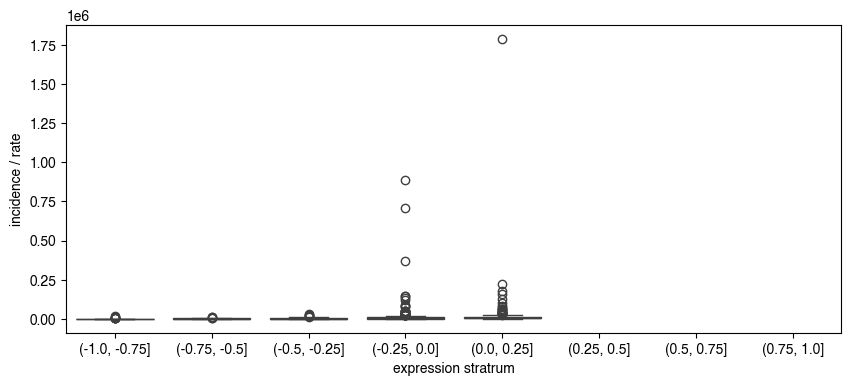

In [46]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=affinity_incidence_rate_df["affinity stratrum"], y=np.log10(affinity_incidence_rate_df["incidence / rate"]))
plt.show()
plt.figure(figsize=(10, 4))
sns.boxplot(data=affinity_incidence_rate_df, x="expression stratrum", y="incidence / rate")
plt.show()

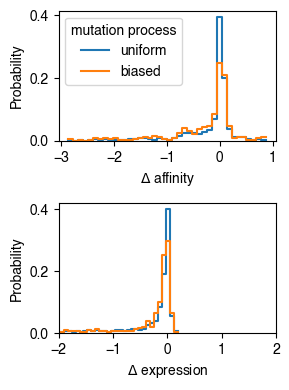

In [47]:
plt.figure(figsize=(3, 4))

ax = plt.subplot(211)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="biased")
# plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ affinity")
# plt.yscale("log")
plt.legend(title="mutation process", fontsize=10)

plt.subplot(212)
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, stat="probability", element="step", fill=False, label="uniform")
sns.histplot(data=dms_df.loc[dms_df.single_nt], x="delta_expr", bins=40, weights=dms_df.loc[dms_df.single_nt, "mutation rate"], stat="probability", element="step", fill=False, label="biased")
plt.xlim(-2, 2)
plt.xlabel(r"$\Delta$ expression")
# plt.yscale("log")


# sns.jointplot(data=dms_df.loc[dms_df.single_nt], x="delta_bind_CGG", y="delta_expr")


plt.tight_layout()
plt.savefig(f"{output_dir}/mutation-bias.pdf")
plt.show()

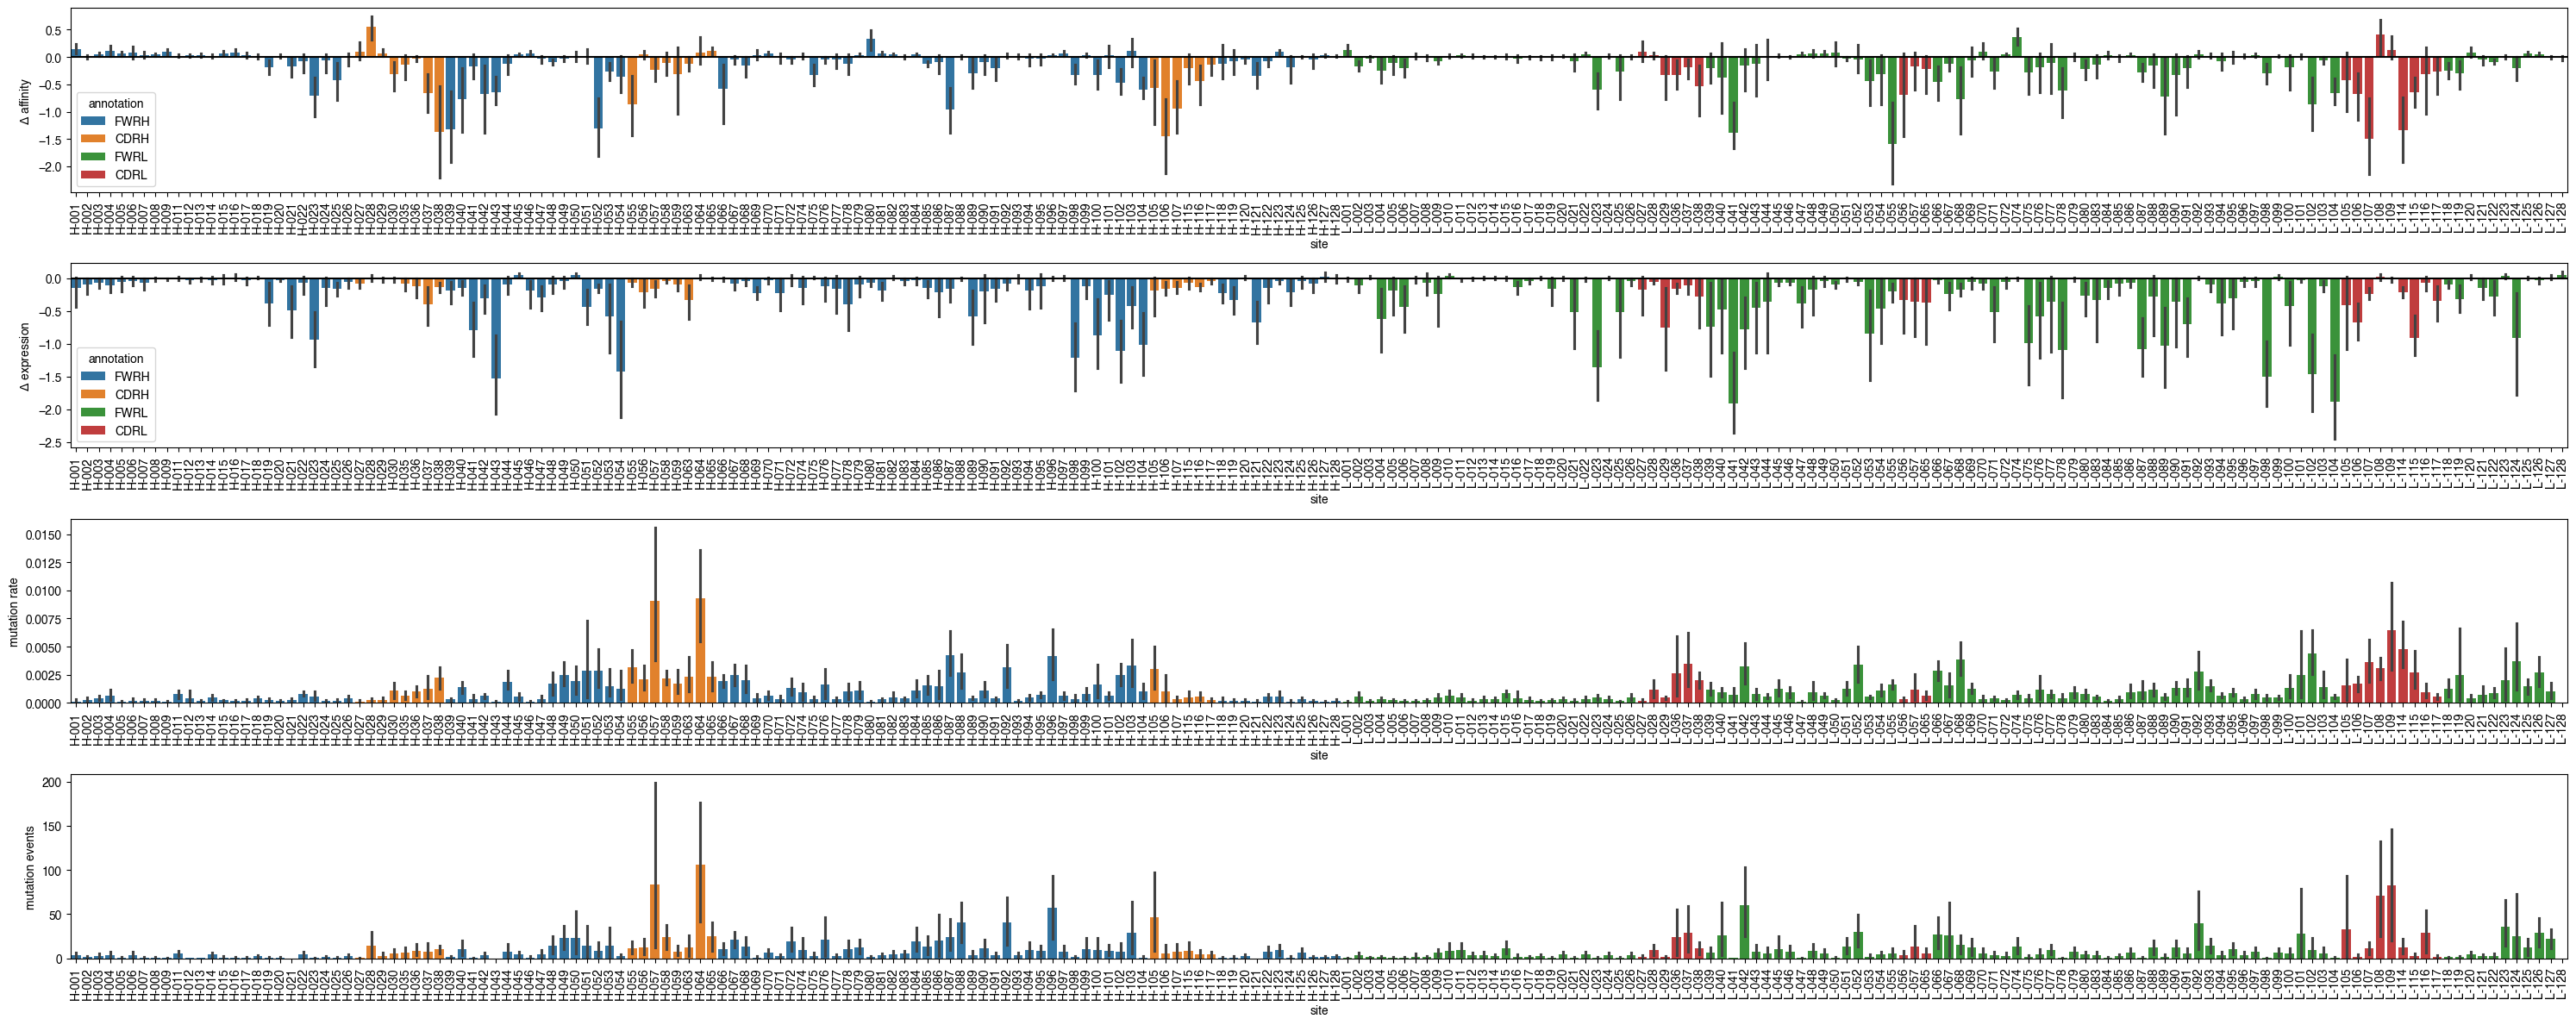

In [48]:
plt.figure(figsize=(30, 12))
plt.subplot(411)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_bind_CGG",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ affinity")
plt.xticks(rotation=90)

plt.subplot(412)
sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="delta_expr",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.axhline(0, c="k")
plt.ylabel(r"$\Delta$ expression")
plt.xticks(rotation=90)

plt.subplot(413)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation rate",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
plt.xticks(rotation=90)
g.legend_.remove()

plt.subplot(414)
g = sns.barplot(data=dms_df.loc[dms_df.single_nt], x="site", y="mutation events",
            hue=dms_df.loc[dms_df.single_nt].annotation.str[:-1],
            order=sorted(dms_df.site.unique()), dodge=False)
g.legend_.remove()
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig(f"{output_dir}/regions.pdf")
plt.show()

## Binding Vs Expression Vs structure

In [49]:
# copypasta from polyclonal
def extract_atom_locations(
    input_pdbfile,
    target_chains,
    target_atom="CA",
):
    # read PDB, catch warnings about discontinuous chains
    with warnings.catch_warnings():
        warnings.simplefilter(
            "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
        )
        pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)

    # get the chains out of the PDB
    chains = list(pdb.get_chains())
    chain_ids = [chain.id for chain in chains]

    # make sure the target chains are in the PDB
    for chain in target_chains:
        if chain not in chain_ids:
            raise ValueError(f"{chain} not in {input_pdbfile}")

    # make a list of chains to extract atom locations from
    chains_to_use = []
    for i, chain in enumerate(chain_ids):
        if chain in target_chains:
            chains_to_use.append(chains[i])

    # extract atom locations from target chains
    chain_list = []
    residue_list = []
    x_list = []
    y_list = []
    z_list = []
    for chain in chains_to_use:
        for residue in chain.get_residues():
            residue_number = residue.get_id()[1]
            atoms = residue.get_atoms()
            for atom in atoms:
                if atom.get_id() == target_atom:
                    x, y, z = atom.get_coord()
                    x_list.append(x)
                    y_list.append(y)
                    z_list.append(z)
                    residue_list.append(residue_number)
                    chain_list.append(chain.id)

    # write output
    output = pd.DataFrame(
        {
            "chain": chain_list,
            "site": residue_list,
            "x": x_list,
            "y": y_list,
            "z": z_list,
        }
    )

    return output.reset_index(drop=True)

In [50]:
# def residue_depth(
#     input_pdbfile,
#     target_chain,
# ):
#     parser = Bio.PDB.PDBParser()
#     # read PDB, catch warnings about discontinuous chains
#     with warnings.catch_warnings():
#         warnings.simplefilter(
#             "ignore", category=Bio.PDB.PDBExceptions.PDBConstructionWarning
#         )
#         pdb = Bio.PDB.PDBParser().get_structure("_", input_pdbfile)
#     model = pdb[0]
#     print(list(pdb.get_chains()))
#     rd = Bio.PDB.ResidueDepth(model)
# #     print(rd)
    
# residue_depth("combined_ch2_eh2-coot_IMGT.pdb", "H")

In [51]:
coords_H = extract_atom_locations(open(pdb), "H").set_index("site").drop("chain", axis=1)
coords_L = extract_atom_locations(open(pdb), "L").set_index("site").drop("chain", axis=1)
coords_A = extract_atom_locations(open(pdb), "A").set_index("site").drop("chain", axis=1)
coords_B = extract_atom_locations(open(pdb), "B").set_index("site").drop("chain", axis=1)
coords_C = extract_atom_locations(open(pdb), "C").set_index("site").drop("chain", axis=1)
coords_D = extract_atom_locations(open(pdb), "D").set_index("site").drop("chain", axis=1)

Add distance info to dms_df

In [52]:
coords_L

,x,y,z
site,,,
1,137.317993,157.432999,169.117004
2,135.832993,154.018005,169.938995
3,134.294006,151.919998,172.697006
4,135.925995,148.505005,172.539001
5,134.113007,146.154007,174.936996
...,...,...,...
119,139.772995,135.639999,181.841003
120,140.578003,131.979996,180.955002
121,139.048996,129.811996,183.735001


In [53]:
for coords_Ab, chain in zip((coords_H, coords_L), "HL"):
    for i in coords_Ab.index:
        min_dist = np.inf
        for coords_Ag in (coords_A, coords_B, coords_C, coords_D):
            chain_min = np.linalg.norm(coords_Ab.loc[i] - coords_Ag, axis=1).min()
            if chain_min < min_dist:
                min_dist = chain_min
        dms_df.loc[(dms_df.chain == chain) & (dms_df.position_IMGT == i), "distance to antigen"] = min_dist

dms_df

,target,wildtype,position,position_IMGT,chain,annotation,mutant,codon,single_nt,bind_CGG,...,mutation events (10-week),mutation abundance (10-week),mutation events (LMP2A),mutation abundance (LMP2A),mutation events,mutation abundance,mutation rate,mutation enrichment,affinity change stratum,distance to antigen
mutation,,,,,,,,,,,,,,,,,,,,,
E1(H)A,CGG_naive,E,1,1,H,FWRH1,A,GAG,True,8.74239,...,0,0,0,0,6,6,0.000006,1.003672,affinity neutral,9.796122
E1(H)C,CGG_naive,E,1,1,H,FWRH1,C,GAG,False,8.60813,...,0,0,0,0,0,0,NaN,NaN,affinity neutral,9.796122
E1(H)D,CGG_naive,E,1,1,H,FWRH1,D,GAG,True,8.63554,...,5,8,0,0,10,57,0.000725,0.479223,affinity neutral,9.796122
E1(H)E,CGG_naive,E,1,1,H,FWRH1,E,GAG,True,8.62305,...,0,0,0,0,0,0,NaN,NaN,affinity neutral,9.796122
E1(H)F,CGG_naive,E,1,1,H,FWRH1,F,GAG,False,8.75738,...,0,0,0,0,0,0,NaN,NaN,affinity neutral,9.796122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R128(L)S,CGG_naive,R,235,128,L,FWRL4,S,CGT,True,8.63400,...,0,0,0,0,0,0,NaN,NaN,affinity neutral,NaN
R128(L)T,CGG_naive,R,235,128,L,FWRL4,T,CGT,False,8.64386,...,0,0,0,0,0,0,NaN,NaN,affinity neutral,NaN
R128(L)V,CGG_naive,R,235,128,L,FWRL4,V,CGT,False,8.58887,...,0,0,0,0,0,0,NaN,NaN,affinity neutral,NaN


In [54]:
dms_df.to_csv(f"{output_dir}/data.csv")

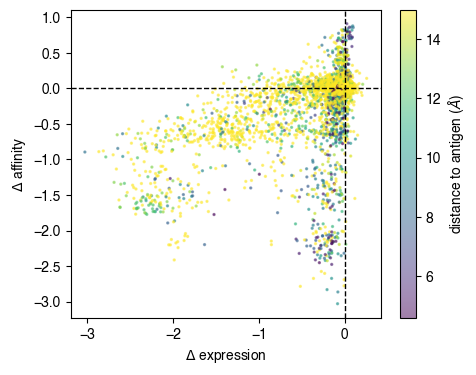

In [55]:
plt.figure(figsize=(5, 4))
plt.scatter(dms_df.delta_expr, y=dms_df.delta_bind_CGG, c=dms_df["distance to antigen"],
            s=2, alpha=0.5,
#             cmap="viridis",
#             vmin=0,
            vmax=15
           )
plt.axvline(0, ls="--", c="k", lw=1)
plt.axhline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ expression")
plt.ylabel(r"$\Delta$ affinity")
plt.colorbar(label=r"distance to antigen ($\AA$)")
# plt.savefig(f"{output_dir}/bind-expr-dist.pdf")
plt.show()

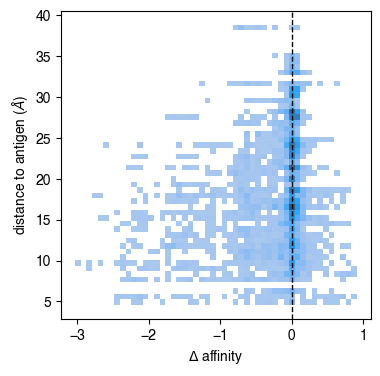

In [56]:
plt.figure(figsize=(4, 4))
sns.histplot(data=dms_df, x="delta_bind_CGG", y="distance to antigen", bins=50)
plt.axvline(0, ls="--", c="k", lw=1)
plt.xlabel(r"$\Delta$ affinity")
plt.ylabel(r"distance to antigen ($\AA$)")
plt.savefig(f"{output_dir}/bind-dist.pdf")
plt.show()

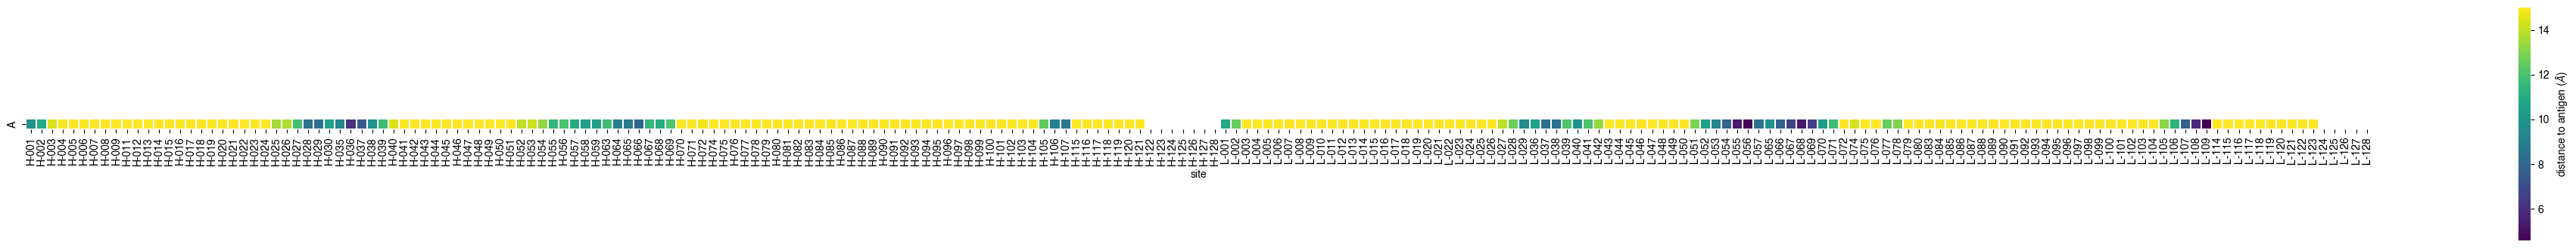

In [57]:
plt.figure(figsize=(50, 4))
sns.heatmap(pd.DataFrame(dms_df.pivot(index="mutant", columns="site", values="distance to antigen").iloc[0, :]).T,
            vmax=15, cmap="viridis",
            cbar_kws=dict(label=r"distance to antigen ($\AA$)"), linewidths=.1, square=True)
plt.savefig(f"{output_dir}/bind-heatmap-distances-row.pdf")
plt.show()

## High-incidence mutations

In [58]:
dms_df[["mutation events", "delta_bind_CGG"]].sort_values("mutation events", ascending=False)[:20]

,mutation events,delta_bind_CGG
mutation,,
S57(H)N,416,0.12761
S64(H)N,287,0.05093
N108(L)K,250,0.85965
Q105(L)H,213,0.38030
S109(L)N,213,0.01231
A105(H)G,195,0.44629
S109(L)R,183,0.79500
E101(L)D,181,-0.11838
S64(H)R,171,0.87785


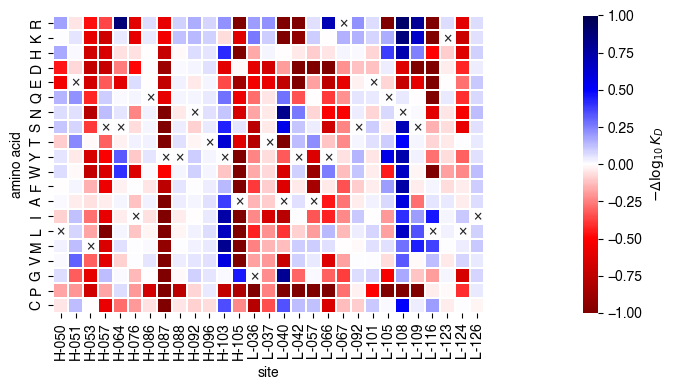

In [59]:
# high_incidence = ["H-057", "H-064", "L-108", "L-109"]
high_incidence = dms_df.loc[dms_df["mutation events"] > dms_df["mutation events"].quantile(0.99)].site.unique()

plt.figure(figsize=(20, 4))
sns.heatmap(bind_df[high_incidence], center=0, vmin=vmin, vmax=vmax, annot=annot[high_incidence], fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$-\Delta\log_{10} K_D$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.tight_layout()
# plt.savefig(f"{output_dir}/high-incidence.pdf")
plt.show()

## Pairwise epistasis

In [60]:
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

In [61]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        parent_mutations = set(mutation for mutation in node.up.mutations)
        new_mutations = set(mutation for mutation in node.mutations) - parent_mutations
        if any(mutation.endswith("*") for mutation in parent_mutations.union(new_mutations)):
            continue
        for new_mutation in new_mutations:
            n_mutations += 1
            mutation_counts[new_mutation] += 1
        for background_mutation in parent_mutations:
            for new_mutation in new_mutations:
                epi_df.loc[background_mutation, new_mutation] += 1

volcano_dat = []
                
for background_mutation in mutations:
    background_total = epi_df.loc[background_mutation, :].sum()
    if background_total >= 5:
        for new_mutation in mutations:
            if background_mutation[:-1] != new_mutation[:-1] and mutation_counts[new_mutation] >= 5:
                print(background_mutation, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 1] = mutation_counts[new_mutation] - epi_df.loc[background_mutation, new_mutation]
                table[1, 0] = background_total - epi_df.loc[background_mutation, new_mutation]
                table[1, 1] = epi_df.loc[background_mutation, new_mutation]
                table[0, 0] = n_mutations - table.sum()
                assert table.sum() == n_mutations
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                if p_value < 1e-6:
                    print(background_mutation, new_mutation, odds_ratio, p_value)
                volcano_dat.append([background_mutation, new_mutation, table, odds_ratio, p_value])

volcano_df = pd.DataFrame(volcano_dat, columns=["background mutation", "mutation event", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

epi_muts = volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")
epi_muts

N108(L)K A105(H)G 0.28165199729180773 5.627099159610112e-07


,background mutation,mutation event,contingency table,odds ratio,p-value,FDR,FDR < 0.05


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_66689/3290763540.py:2: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  ax = sns.scatterplot(data=volcano_df, x="odds ratio", y="p-value", hue=f"FDR < {FDR_tresh}", palette=["lightgrey", "red"])


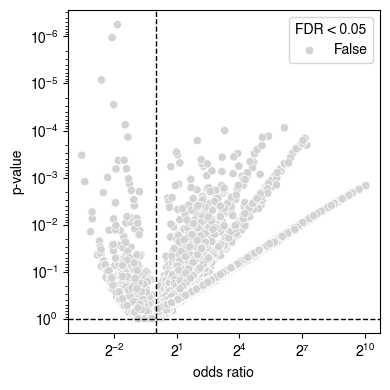

In [62]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(data=volcano_df, x="odds ratio", y="p-value", hue=f"FDR < {FDR_tresh}", palette=["lightgrey", "red"])
ax.invert_yaxis()
plt.axvline(1, ls="--", c="k", lw=1)
plt.axhline(1, ls="--", c="k", lw=1)
# plt.axhline(volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], "p-value"].max(), ls="--", c="red", lw=1)
plt.xscale("log", base=2)
plt.yscale("log")
plt.tight_layout()
plt.savefig(f"{output_dir}/epistasis.volcano.pdf")
plt.show()

In [63]:
epi_muts.to_csv(f"{output_dir}/epistatic-pairs.csv", index=False)

Where are the above mutations in our scatters?

In [64]:
background_indicator = dms_df.index.isin(epi_muts["background mutation"])
enabled_indicator = dms_df.index.isin(epi_muts["mutation event"])
indicator = ["other"] * len(dms_df)
for i in range(len(indicator)):
    if background_indicator[i]:
        indicator[i] = "epistatic background mutation"
    elif enabled_indicator[i]:
        indicator[i] = "epistatically enabled mutation"
indicator = pd.Series(indicator, index=dms_df.index, name="mutation type")

# indicator = dms_df.index == "A40(L)G" #"A40(L)G"

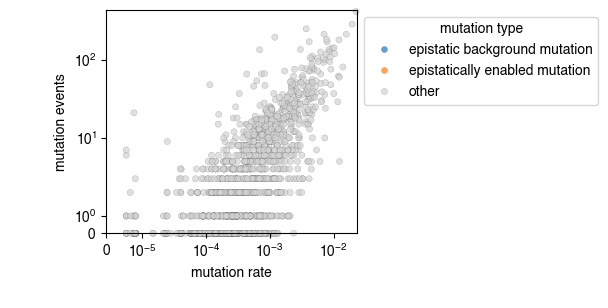

In [65]:
plt.figure(figsize=(6, 3))

ax = sns.scatterplot(x=dms_df["mutation rate"], y=dms_df["mutation events"], hue=indicator, s=20, alpha=0.7,
                     hue_order=("epistatic background mutation", "epistatically enabled mutation", "other"),
                     palette=("C0", "C1", "lightgrey"),
                     clip_on=False, edgecolors="k", linewidths=0.1)
# plt.xlabel("mutation rate")
plt.ylabel("mutation events")
linthresh_x = 1e-5
linthresh_y = 1.0
plt.xscale("symlog", linthresh=linthresh_x, linscale=.5)
plt.yscale("symlog", linthresh=linthresh_y, linscale=.2)
plt.xlim(0, None)
plt.ylim(0, None)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(f"{output_dir}/eventsVsrate-epistatic.pdf")
plt.show()

LBI of nodes with the above mutations

,LBI,LBR,mutation pair on tree node


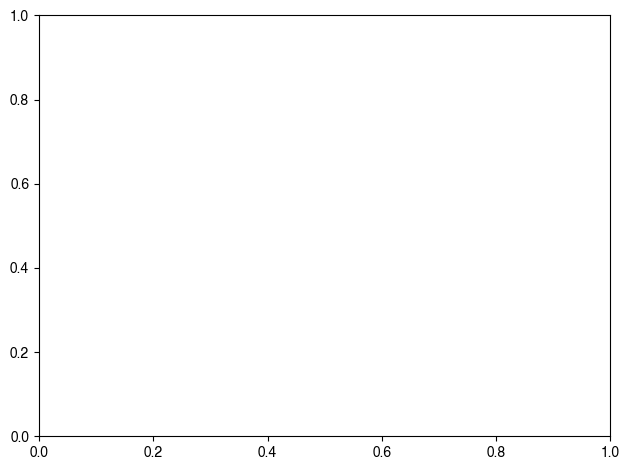

In [66]:
lbi_dat = []
pairs = set((x, y) for x, y in volcano_df.loc[volcano_df[f"FDR < {FDR_tresh}"], ["background mutation", "mutation event"]].values)
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        mutations = set(node.mutations)
        # if node.get_distance(tree.tree) <= 4:
        if len(mutations) == 2:
            if any(set(pair) <= mutations for pair in pairs):            
                lbi_dat.append([node.LBI, node.LBR, "enabling and enabled mutation"])
            elif any(pair[0] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabling mutation only"])
            elif any(pair[1] in mutations for pair in pairs):
                lbi_dat.append([node.LBI, node.LBR, "enabled mutation only"])
            # else:
            #     lbi_dat.append([node.LBI, node.LBR, "none"])

lbi_df = pd.DataFrame(lbi_dat, columns=("LBI", "LBR", "mutation pair on tree node"))

display(lbi_df)

# plt.figure(figsize=(10, 3))
sns.boxplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), fliersize=0)
sns.swarmplot(data=lbi_df, y="mutation pair on tree node", x="LBI", order=("enabled mutation only", "enabling mutation only", "enabling and enabled mutation"), color="k", size=3)
plt.tight_layout()
# plt.savefig(f"{output_dir}/epistasis.LBI.pdf")
plt.show()


In [67]:
from scipy.stats import kruskal, mannwhitneyu

kruskal(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
        lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_66689/89517539.py:3: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  kruskal(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,


KruskalResult(statistic=np.float64(nan), pvalue=np.float64(nan))

In [68]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI)

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_66689/1175393541.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,


MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))

In [69]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_66689/1372644802.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabled mutation only"].LBI,


MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))

In [70]:
mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,
             lbi_df[lbi_df["mutation pair on tree node"] == "enabling and enabled mutation"].LBI)

/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_66689/1582679550.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  mannwhitneyu(lbi_df[lbi_df["mutation pair on tree node"] == "enabling mutation only"].LBI,


MannwhitneyuResult(statistic=np.float64(nan), pvalue=np.float64(nan))

### Redoing above using Yun's approach of coincidence of mutations on nodes

In [71]:
n_mutations, mutation_counts.sum()

(16892, np.int64(16892))

In [72]:
mutations =  dms_df.index.unique()

n_mutations = 0
mutation_counts = pd.Series(0, index=mutations)

epi_df = pd.DataFrame(np.zeros((len(mutations), len(mutations))), index=mutations, columns=mutations)

for gc, tree in trees.items():
    print(gc, end="       \r")
    for node in tree.tree.iter_descendants(strategy="preorder"):
        if any(mutation.endswith("*") for mutation in node.mutations):
            continue
        for i, mutation1 in enumerate(node.mutations):
            n_mutations += 1
            mutation_counts[mutation1] += 1
            for mutation2 in node.mutations[i + 1:]:
                epi_df.loc[mutation1, mutation2] += 1

volcano_dat = []
                
for i, mutation1 in enumerate(mutations):
    mutation1_total = mutation_counts[mutation1]
    if mutation1_total >= 50:
        for mutation2 in mutations[i + 1:]:
            if mutation1[:-1] != mutation2[:-1] and mutation_counts[mutation2] >= 5:
                print(mutation1, end="       \r")
                table = np.zeros((2, 2), dtype=int)
                table[0, 0] = n_mutations - epi_df.loc[mutation1, mutation2]
                table[0, 1] = mutation_counts[mutation2] - epi_df.loc[mutation1, mutation2]
                table[1, 0] = mutation1_total - epi_df.loc[mutation1, mutation2]
                table[1, 1] = epi_df.loc[mutation1, mutation2]
                
                odds_ratio, p_value = fisher_exact(table, alternative="two-sided")
                row = [mutation1, mutation2, table, odds_ratio, p_value]
                # if p_value < 1e-6:
                #     print(row)
                volcano_dat.append(row)

volcano_df = pd.DataFrame(volcano_dat, columns=["mutation 1", "mutation 2", "contingency table", "odds ratio", "p-value"])

_, volcano_df["FDR"] = fdrcorrection(volcano_df["p-value"], method="p")

FDR_tresh = 0.05
volcano_df[f"FDR < {FDR_tresh}"] = volcano_df.FDR < FDR_tresh

volcano_df[volcano_df[f"FDR < {FDR_tresh}"]].sort_values("p-value")

,mutation 1,mutation 2,contingency table,odds ratio,p-value,FDR,FDR < 0.05
12115,S57(H)N,S64(H)R,"[[46552, 586], [1003, 405]]",32.077079,0.000000,0.000000,True
17640,S64(H)R,A105(H)G,"[[46280, 4321], [314, 677]]",23.092349,0.000000,0.000000,True
36820,A105(H)G,N108(L)K,"[[45683, 764], [3724, 1274]]",20.456014,0.000000,0.000000,True
12276,S57(H)N,A105(H)G,"[[46109, 4150], [560, 848]]",16.824627,0.000000,0.000000,True
42898,Y42(L)F,Q105(L)H,"[[46585, 1021], [417, 372]]",40.703077,0.000000,0.000000,True
...,...,...,...,...,...,...,...
6328,N48(H)K,K127(L)I,"[[46955, 72], [62, 2]]",21.037186,0.004611,0.049802,True
23095,S74(H)G,N85(H)S,"[[46954, 116], [129, 3]]",9.413392,0.004621,0.049894,True
24282,I76(H)V,K51(L)Q,"[[46955, 28], [157, 2]]",21.362602,0.004622,0.049894,True
6873,K49(H)E,S109(L)R,"[[46949, 722], [161, 8]]",3.231121,0.004624,0.049909,True


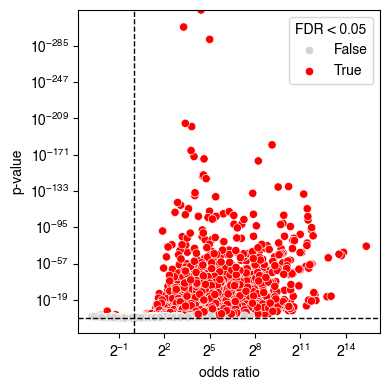

In [73]:
plt.figure(figsize=(4, 4))
ax = sns.scatterplot(data=volcano_df, x="odds ratio", y="p-value", hue=f"FDR < {FDR_tresh}", palette=["lightgrey", "red"])
ax.invert_yaxis()
plt.axvline(1, ls="--", c="k", lw=1)
plt.axhline(1, ls="--", c="k", lw=1)
plt.xscale("log", base=2)
plt.yscale("log")
plt.tight_layout()
plt.show()